# Project 6 : FMT - Regression 

## Pre read note

#1.It is assumed that 0 in the source data is a valid value that has business context.
#2.Data is evalauted for integrated model and for split models for split data ( 1 model for each cluster) since there are multiple gaussians noted.
#3.Hence clustering is also done , using K means and GaussianMixture approach.
#4.Linear vs Polinomial is also evaluated for model performance.
#5.Feature selection using various methods (RFE, OLS,DT,SFS) is also evaluated.
#6.Base models (independent as well as ensemble) are initially built to compare the results acros various data variants and model approaches.
#7.Out of this, it is evaluated if cluster based model is better than integrated model.
#8.For evaluating cluster vs integrated model, it is evaluated if all clusters give better performance than integrated model.
#9.Based on this, selected set of data / models are further picked up for tuning the parameters to evalate performance.
#10.Finally stacked approach is also done to compare the results.

## 1.Import necessary libraries

In [1]:
# suppress warnings

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# load basic libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import time

# load libraries related to model building and evaluation
 
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn import metrics
from math import sqrt
from matplotlib import cm
import shap


In [2]:
# Creating data frame to capture comparison output of all models

# dataframe to compare model evaluation output

scompdf = pd.DataFrame(columns=['Model','Variant','No.of features','Type','R2_Train','R2','RMSE','R2:CV Mean','R2:Range @95% CL'])

# dataframe to compare model co-efficient and feature importance outputs

paramcompdf = pd.DataFrame(columns=['Model','Variant','No.of features','Type','Intercept','Coeff_cement','Coeff_slag','Coeff_ash','Coeff_water','Coeff_superplastic','Coeff_coarseagg','Coeff_fineagg','Coeff_age'])
ficompdf = pd.DataFrame(columns=['Model','Variant','No.of features','Type','cement','slag','ash','water','superplastic','coarseagg','fineagg','age'])


## 2. Load Data

In [3]:
# data is loaded to 2 dataframes. rawdata and mydata. 
#rawdata will represent the original data and mydata will be updated for transformations

myfile = "concrete.csv"
rawdata = pd.read_csv(myfile) 
mydata = pd.read_csv(myfile)
rawdata.sample(10)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
387,218.2,54.6,123.8,140.8,11.9,1075.7,792.7,14,35.96
67,238.1,0.0,94.1,186.7,7.0,949.9,847.0,100,44.30
236,213.7,98.1,24.5,181.7,6.9,1065.8,785.4,3,18.00
569,475.0,118.8,0.0,181.1,8.9,852.1,781.5,56,72.30
765,146.5,114.6,89.3,201.9,8.8,860.0,829.5,28,19.99
568,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,3,13.12
101,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
360,149.0,139.0,109.0,193.0,6.0,892.0,780.0,28,23.69
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42
565,182.0,45.2,122.0,170.2,8.2,1059.4,780.7,56,43.50


## 3. EDA, Univariate/Bivariate/Multivariate Attribute Analysis

In [4]:
#understanding column datatypes , number of columns,rows 
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
# creating function for counting outliers ( based on IQR )
def outliercount(attr,df):
    Q1 = df[attr].quantile(0.25)
    Q3 = df[attr].quantile(0.75)
    IQR = Q3-Q1
    outlier_count=((df[attr]<(Q1-(1.5*IQR))) | (df[attr]>(Q3+(1.5*IQR)))).sum()
    return outlier_count

# EDA using custom built dataframe for analyzing attributes of type integer

Item=[]
for attr in mydata.select_dtypes(include=['integer','float64']).columns:
    Item.append([
        attr,mydata[attr].dtype,
        mydata[attr].isna().sum(),
        round((mydata[attr].isna().sum()/len(mydata[attr]))*100,2),
        mydata[attr].nunique(),
        list(mydata[attr].sample(5).drop_duplicates().values),
        mydata[attr].count(),
        len(mydata[mydata[attr]<0]),
        mydata[attr].std(),
        mydata[attr].min(),
        mydata[attr].quantile(.25),
        mydata[attr].quantile(.50),
        mydata[attr].mean(),
        mydata[attr].quantile(0.75),
        mydata[attr].max(),
        mydata[attr].skew(),
        outliercount(attr,mydata),
        round((outliercount(attr,mydata)/mydata[attr].count())*100,2)
    ]);
    
eda=pd.DataFrame(data=Item,columns=['Attribute','Datatype','Null','Null%',\
                                    'Unique','Sample','Count','-Ve Data',\
                                    'Stddev','Min','25%','50%','Mean','75%',\
                                    'Max','Skew','No.# Outlier','% Outlier'])

eda.round(2)

,Attribute,Datatype,Null,Null%,Unique,Sample,Count,-Ve Data,Stddev,Min,25%,50%,Mean,75%,Max,Skew,No.# Outlier,% Outlier
0,cement,float64,0,0.0,278,"[108.3, 540.0, 139.9, 313.0, 182.0]",1030,0,104.51,102.00,192.38,272.90,281.17,350.00,540.0,0.51,0,0.00
1,slag,float64,0,0.0,185,"[0.0, 47.5]",1030,0,86.28,0.00,0.00,22.00,73.90,142.95,359.4,0.80,2,0.19
2,ash,float64,0,0.0,156,"[0.0, 163.3, 124.8]",1030,0,64.00,0.00,0.00,0.00,54.19,118.30,200.1,0.54,0,0.00
3,water,float64,0,0.0,195,"[156.8, 206.0, 162.1, 186.0, 158.1]",1030,0,21.35,121.80,164.90,185.00,181.57,192.00,247.0,0.07,9,0.87
4,superplastic,float64,0,0.0,111,"[0.0, 15.0, 7.9, 11.6]",1030,0,5.97,0.00,0.00,6.40,6.20,10.20,32.2,0.91,10,0.97
5,coarseagg,float64,0,0.0,284,"[822.0, 884.9, 1021.0, 932.0, 1111.0]",1030,0,77.75,801.00,932.00,968.00,972.92,1029.40,1145.0,-0.04,0,0.00
6,fineagg,float64,0,0.0,302,"[777.5, 774.0, 815.9, 722.5, 594.0]",1030,0,80.18,594.00,730.95,779.50,773.58,824.00,992.6,-0.25,5,0.49
7,age,int64,0,0.0,14,"[28, 3, 365, 7]",1030,0,63.17,1.00,7.00,28.00,45.66,56.00,365.0,3.27,59,5.73
8,strength,float64,0,0.0,845,"[33.21, 11.85, 9.56, 11.47, 39.44]",1030,0,16.71,2.33,23.71,34.44,35.82,46.14,82.6,0.42,4,0.39


#### Based on the above we can infer the following:

#1.There are no null values in any of the attribues.
#2.There are no negative values in any of the attributes.
#3.Most of the attributes have skeweness ( ranging from small to large). Age attribute is heavily skewed.
#4.There are outliers in most of the attribues(6/9).However interms of number of records the missing data is less than 1%, except for Age attribute where close to 6% of data has outliers. 
#5.These outliers need to be reviewed to decide how to handle the same.

Skewness of cement distribution = 0.51
Mean of cement distribution = 281.17
Median of cement distribution = 272.90
Number of outliers in cement distribution = 0.00


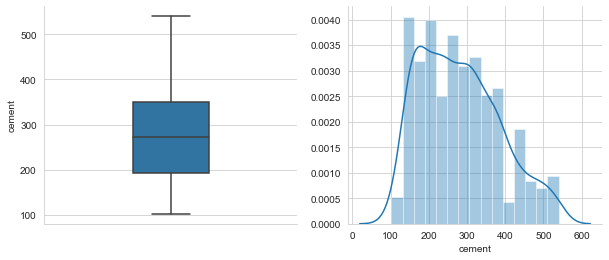

In [6]:
# Analysis of Attribute: cement
curattr = 'cement'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )


#### Based on the above we can infer the following

#1.There are no outliers.
#2.Mean and Median are far.
#3.Distribution has skewness. 
#4.Multiple gaussians noted.

Skewness of slag distribution = 0.80
Mean of slag distribution = 73.90
Median of slag distribution = 22.00
Number of outliers in slag distribution = 2.00


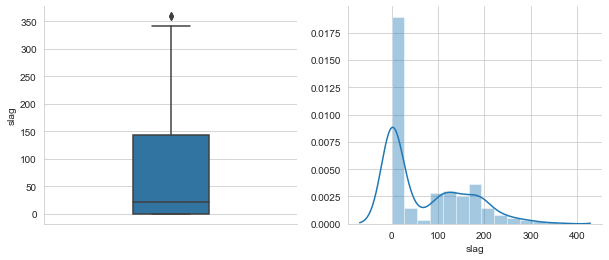

In [7]:
# Analysis of Attribute: slag
curattr = 'slag'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are outliers.
#2.Mean and Median are very far.
#3.Distribution has skewness. 
#4.Multiple gaussians noted.

Skewness of ash distribution = 0.54
Mean of ash distribution = 54.19
Median of ash distribution = 0.00
Number of outliers in ash distribution = 0.00


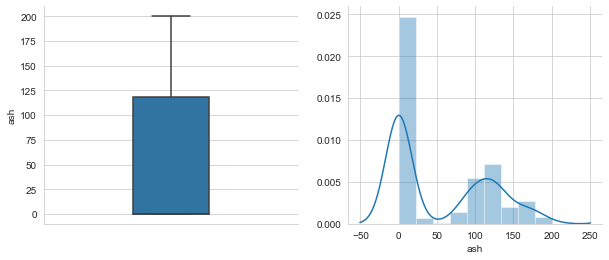

In [8]:
# Analysis of Attribute: ash
curattr = 'ash'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are no outliers.
#2.Mean and Median are very far.
#3.Distribution has skewness.
#4.Multiple gaussians noted.

Skewness of water distribution = 0.07
Mean of water distribution = 181.57
Median of water distribution = 185.00
Number of outliers in water distribution = 9.00


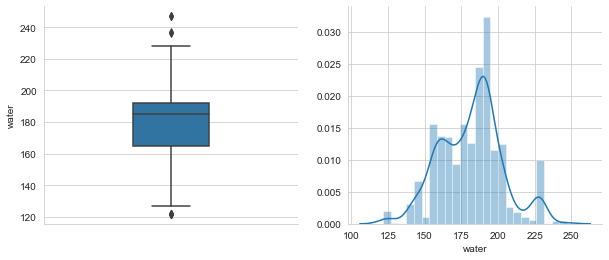

In [9]:
# Analysis of Attribute: water
curattr = 'water'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are  outliers.
#2.Mean and Median are far.
#3.Distribution has skewness.
#4.Multiple gaussians noted.

Skewness of superplastic distribution = 0.91
Mean of superplastic distribution = 6.20
Median of superplastic distribution = 6.40
Number of outliers in superplastic distribution = 10.00


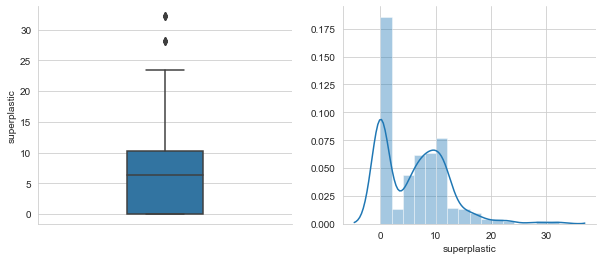

In [10]:
# Analysis of Attribute: superplastic
curattr = 'superplastic'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are outliers.
#2.Mean and Median are not very close.
#3.Distribution has skewness.
#4.Multiple gaussians noted.

Skewness of coarseagg distribution = -0.04
Mean of coarseagg distribution = 972.92
Median of coarseagg distribution = 968.00
Number of outliers in coarseagg distribution = 0.00


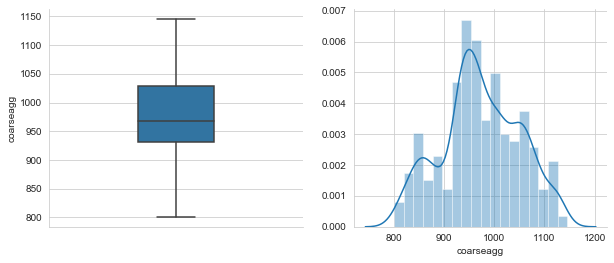

In [11]:
# Analysis of Attribute: coarseagg
curattr = 'coarseagg'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are no outliers.
#2.Mean and Median are far.
#3.Distribution has skewness.
#4.Multiple gaussians noted.

Skewness of fineagg distribution = -0.25
Mean of fineagg distribution = 773.58
Median of fineagg distribution = 779.50
Number of outliers in fineagg distribution = 5.00


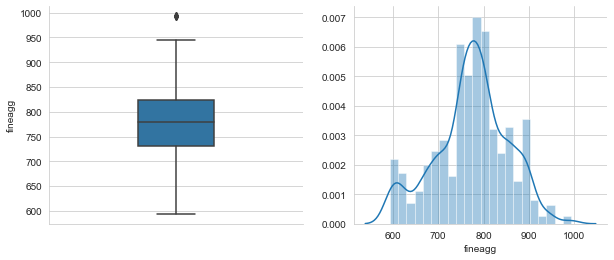

In [12]:
# Analysis of Attribute: fineagg
curattr = 'fineagg'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are outliers.
#2.Mean and Median are not very close.
#3.Distribution has skewness.
#4.Multiple gaussians noted.

Skewness of age distribution = 3.27
Mean of age distribution = 45.66
Median of age distribution = 28.00
Number of outliers in age distribution = 59.00


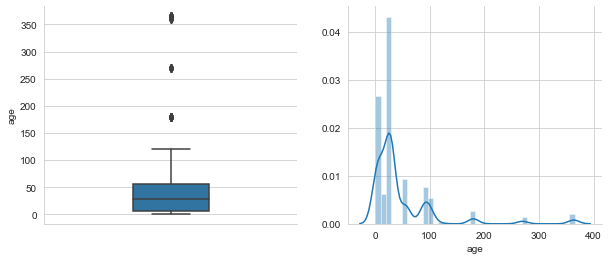

In [13]:
# Analysis of Attribute: age
curattr = 'age'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are outliers.
#2.Mean and Median are very far.
#3.Distribution has skewness.
#4.Multiple gaussians noted.

Skewness of strength distribution = 0.42
Mean of strength distribution = 35.82
Median of strength distribution = 34.45
Number of outliers in strength distribution = 4.00


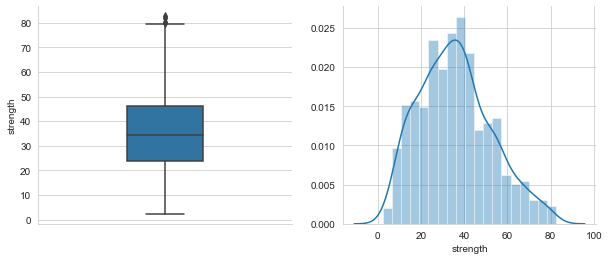

In [14]:
# Analysis of Attribute: strength
curattr = 'strength'
f,axes = plt.subplots(1,2)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.despine()
plt.gcf().set_size_inches(10, 4)
curattr_skew = mydata[curattr].skew()
curattr_mean = mydata[curattr].mean()
curattr_med = mydata[curattr].median()
curattr_null = mydata[curattr].isna().sum()
curattr_outl = outliercount(curattr,mydata)
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )
print('Mean of ' + curattr +' distribution = %1.2f' %(curattr_mean) )
print('Median of ' + curattr +' distribution = %1.2f' %(curattr_med) )
print('Number of outliers in ' + curattr +' distribution = %1.2f' %(curattr_outl) )

#### Based on the above we can infer the following

#1.There are outliers.
#2.Mean and Median are far.
#3.Distribution has skewness.
#4.Distribution seems fairly normally distributed but multiple gaussians noted.

### Outliers handling:

In [15]:
# Number of outliers in data before handling outliers

attroutl=('slag',  'water', 'superplastic', 'fineagg', 'age')

print('Number of outliers:')
print()

for  attr in attroutl:
    print(attr,outliercount(attr,mydata))
    ;

Number of outliers:

slag 2
water 9
superplastic 10
fineagg 5
age 59


#1. There are several approaches to handling outliers. 
#2. We will apply 2 techniques here: (1) replacing with class median value  - for some and (2) perform log transformation - for some.

In [16]:
# replacing outliers with class median values 

attrout2=['water','fineagg']

for attr in attrout2:
    mydata['temp'] = mydata[attr].median()
    rind = mydata.loc[((mydata[attr]<(mydata[attr].quantile(0.25)-(1.5*(mydata[attr].quantile(0.75) - mydata[attr].quantile(0.25))))) | (mydata[attr]>(mydata[attr].quantile(0.75)+(1.5*(mydata[attr].quantile(0.75) - mydata[attr].quantile(0.25))))))].index.values
    cind = mydata.columns.get_loc(attr)
    mydata.iloc[rind,cind] = mydata.loc[rind,'temp']
    mydata.drop('temp',axis=1,inplace=True)
    ;
   

In [17]:
# replacing outliers with log transformation

attrout3=('slag', 'superplastic', 'age')

for attr in attrout3:
    mydata[attr]=np.log1p(mydata[attr])
    ;


In [18]:
# Number of outliers in data after handling outliers

print('Number of outliers:')
print()

for  attr in attroutl:
    print(attr,outliercount(attr,mydata))
    ;

Number of outliers:

slag 0
water 0
superplastic 0
fineagg 30
age 0


#1.We can note that number of outliers in fineagg attribute is now 30. 

### Coorelation, Covariance and Pairplot analysis:

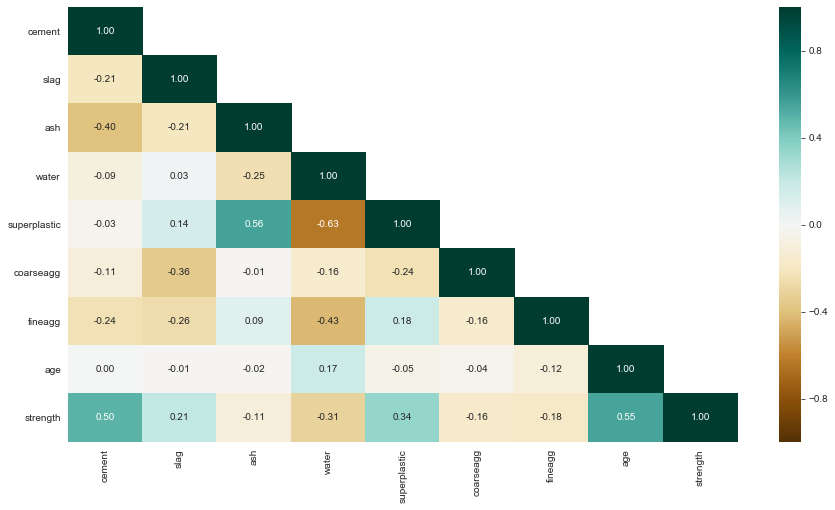

In [19]:
#Correlation analysis

corr = mydata.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, cmap="BrBG",fmt='.2f',vmin=-1,vmax=1)
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=0)
plt.gcf().set_size_inches(15, 8)

#### Based on the above we can infer the following 

#1.There is no one single attribute which has very significant correlation with strength. However cement and age seem to show highest positive correlation with strength.
#2.Similarly water highest negative correlation with class.
#3.However, among the attributes, there are several reasonable correlations observed.
#4.For example, superplastic has 0.56 correlation with ash and -0.63 correlation with water.
#5.Since there is no significant inter attribute correction , except in few case, PCA may not be effective in reducting dimensions.

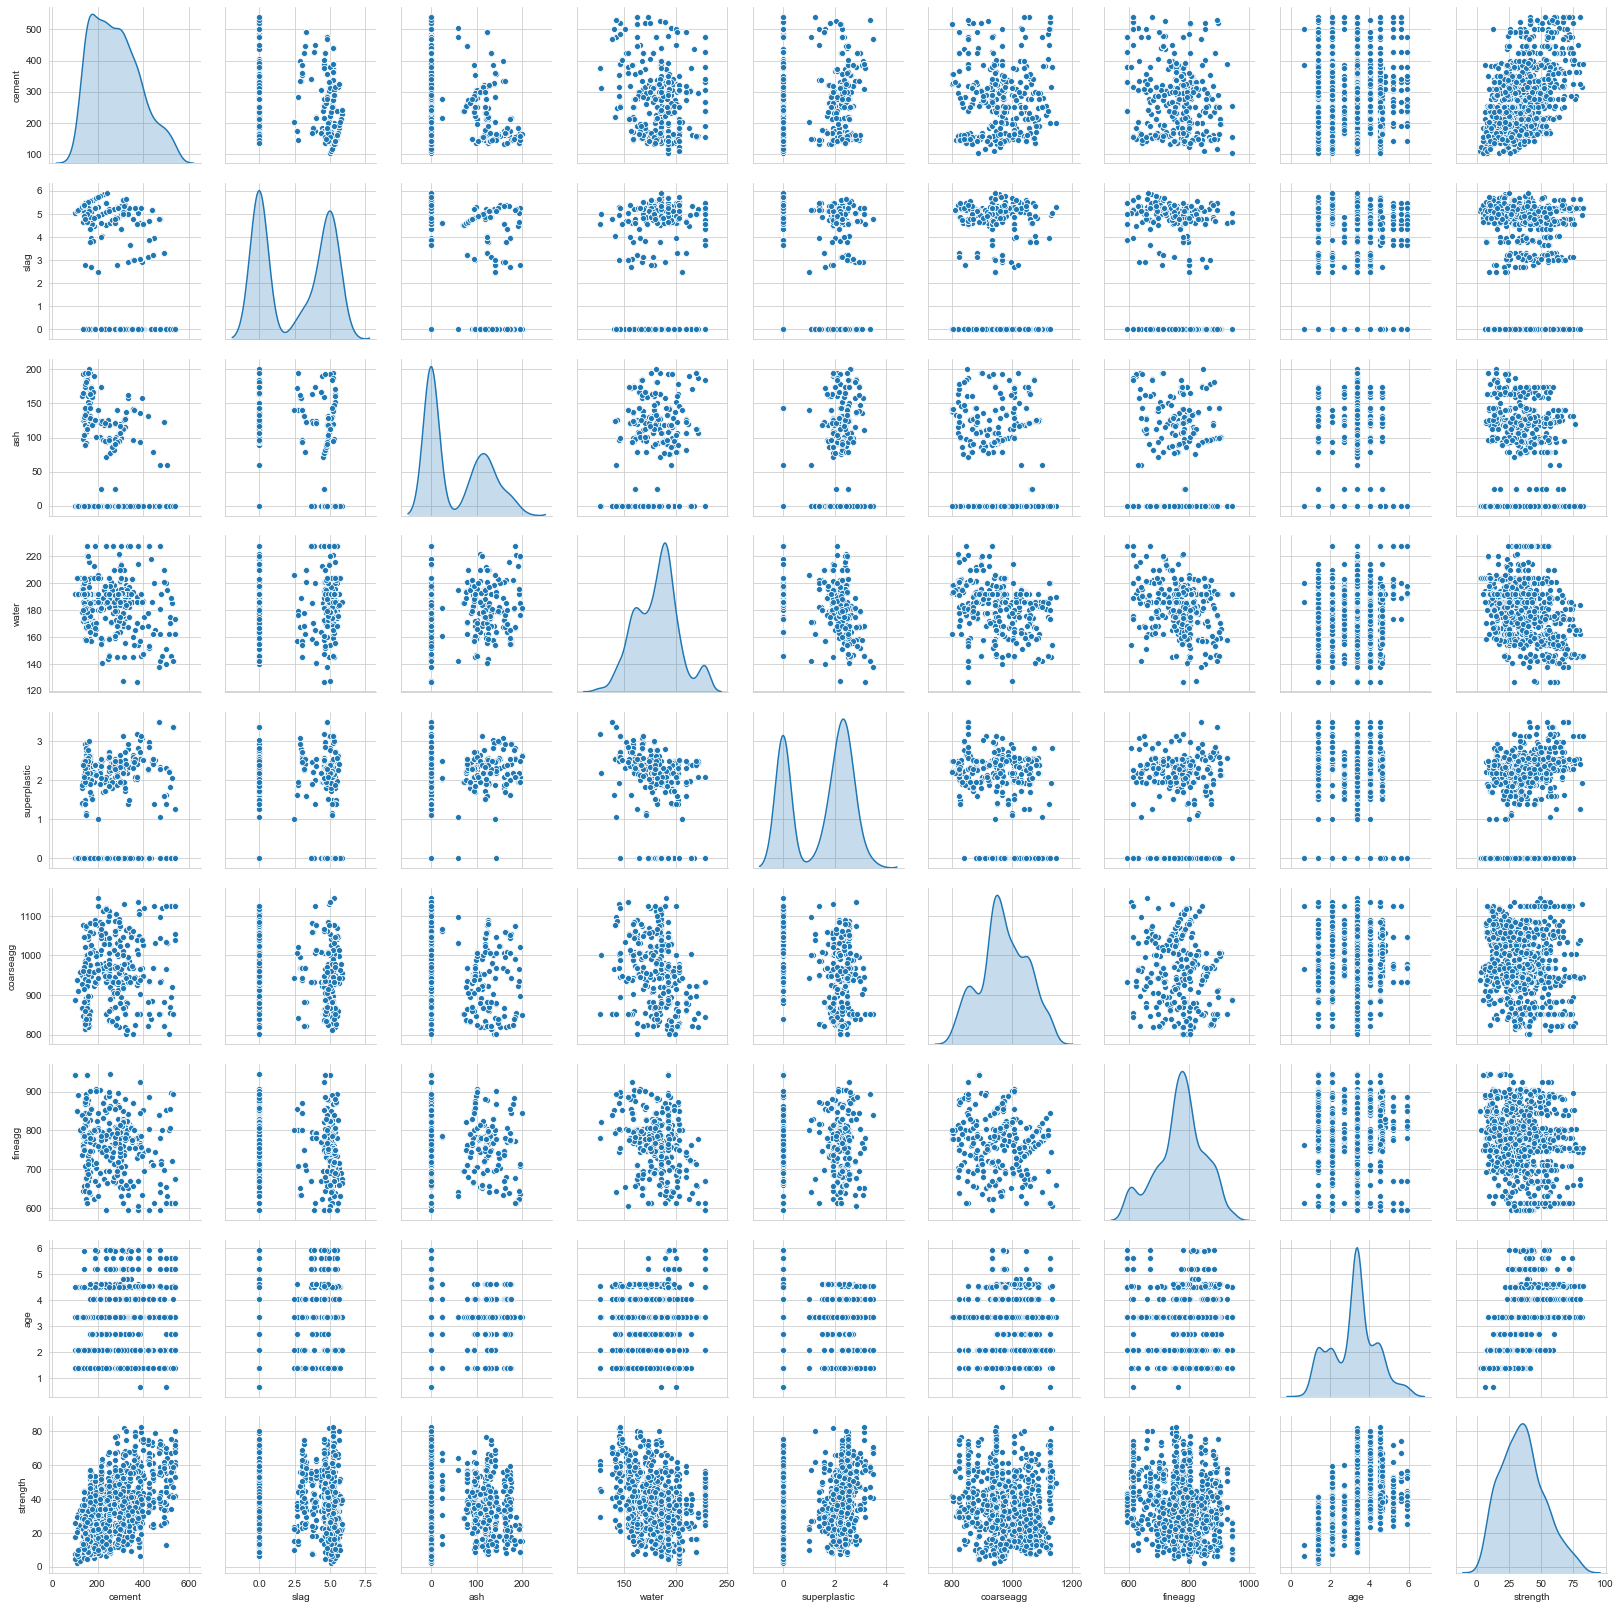

In [20]:
# pairplot
sns.pairplot(data=mydata,diag_kind='kde')

#### Based on the above we can infer the following 

#1.The diagnal kde plots clearly inidiate multiple gaussians are present.
#2.there are very limited set of attribute combinations that indicate any correlation (e.g.strength - cement)

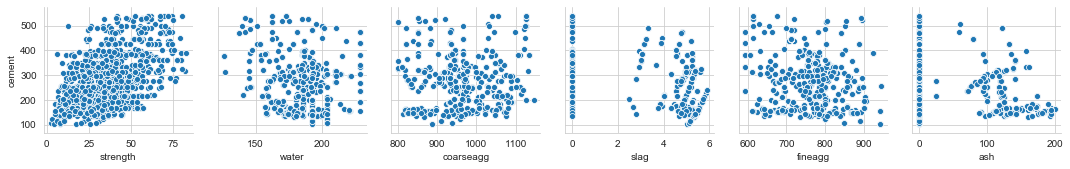

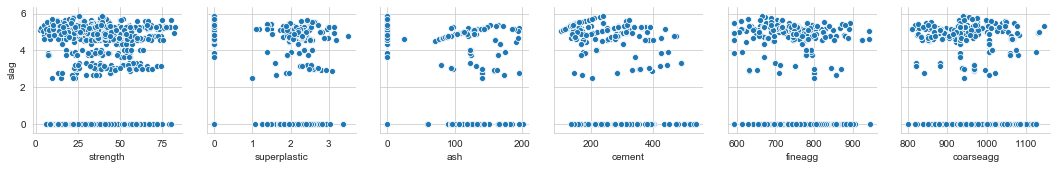

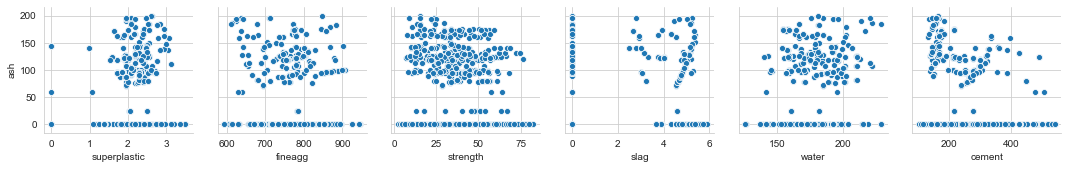

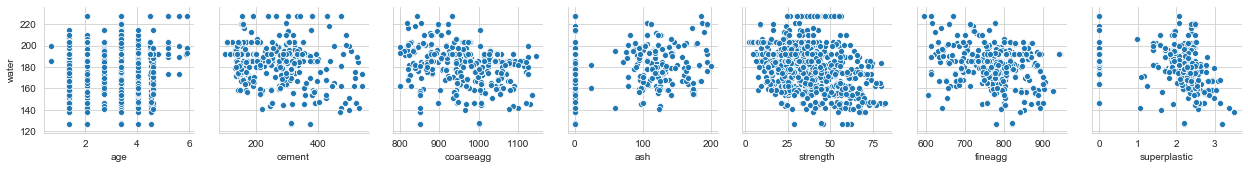

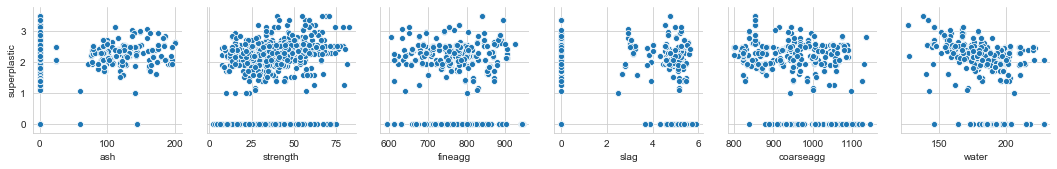

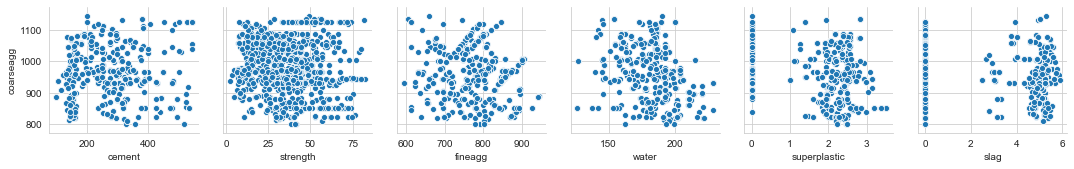

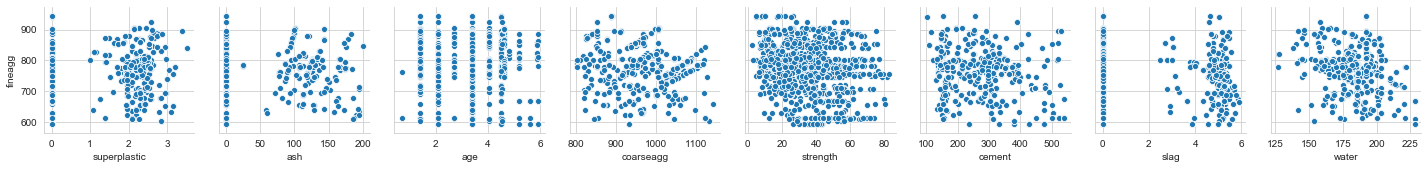

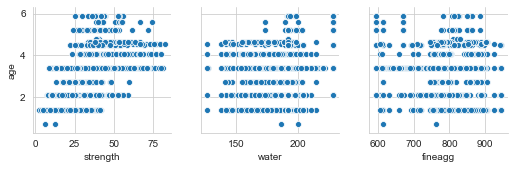

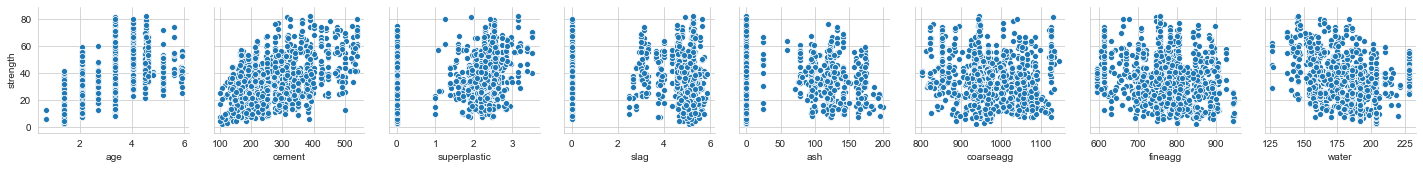

In [21]:
# scatter plot - attributes relationship with other attributes where correlation is more than 5% 


mydata_corr = mydata.corr().round(2)
col = list(mydata_corr.columns)
#col = col[:-1]

for c in col:
    ind = mydata_corr[c][abs(mydata_corr[c])>.05].sort_values(ascending=False).index.values
    ind2 = np.delete(ind, 0,0)
    if len(ind2)>1:
        sns.pairplot(data=mydata,y_vars=[c],x_vars=(ind2))
    else:
        pass
    ; 

#### Based on the above we can infer the following 

#1.The above clearly shows there is no visible significant direct/ indirect correlation between independant attributes.

### Clustering approach:

In [22]:
#Clustering using K Means

mydata_z =mydata.apply(zscore)
cluster_range = range(1,10)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(mydata_z)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df[0:20]

,num_clusters,cluster_errors
0,1,9270.000000
1,2,7390.928416
2,3,6175.180446
3,4,5440.815481
4,5,4916.042671
5,6,4585.788037
6,7,4147.110520
7,8,3876.402769
8,9,3680.883551


[<matplotlib.lines.Line2D at 0x1c23a45cc0>]

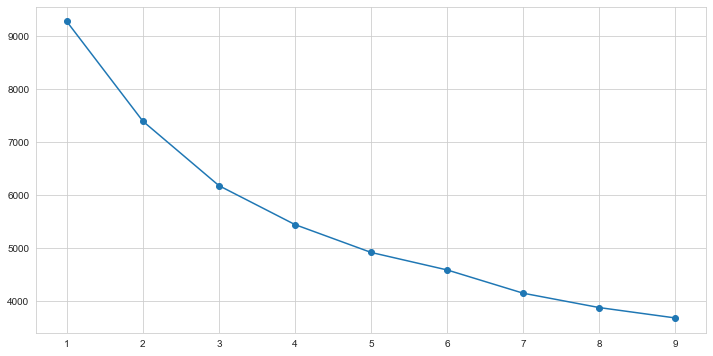

In [23]:
# identify the K value using elbow method

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [24]:
# creating 4 clsuters using K means

kmeans = KMeans(n_clusters=4, n_init = 10, random_state=9)
kmeans.fit(mydata_z)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=9, tol=0.0001, verbose=0)

In [25]:
# Count of data in each cluster

labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
print(counts)

[222 216 336 256]


In [26]:
# Add cluster to data

predictions = kmeans.predict(mydata_z)
predictions
mydata_clustered = mydata.copy(deep= True)
mydata_clustered["group"] = predictions
mydata_clustered['group'] = mydata_clustered['group'].astype('category')
mydata_clustered.group.value_counts()

2    336
3    256
0    222
1    216
Name: group, dtype: int64

In [27]:
mydata_clustered.sample(10)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,group
768,250.2,5.122773,0.0,203.5,0.000000,977.6,694.1,3.367296,36.96,3
472,288.0,5.262690,0.0,192.0,0.000000,932.0,717.8,3.367296,38.80,3
216,246.8,0.000000,125.1,143.3,2.564949,1086.8,800.9,4.615121,66.42,2
447,375.0,4.551769,0.0,126.6,3.194583,852.1,779.5,2.079442,45.70,0
203,231.8,0.000000,121.6,174.0,2.041220,1056.4,778.5,4.615121,45.84,2
615,491.0,3.295837,123.0,210.0,1.589235,882.0,699.0,4.043051,59.59,0
196,231.8,0.000000,121.6,174.0,2.041220,1056.4,778.5,2.708050,26.77,2
913,318.8,5.363637,0.0,155.7,2.727853,852.1,880.4,4.043051,66.10,0
666,310.0,0.000000,0.0,192.0,0.000000,970.0,850.0,3.367296,27.92,1
485,133.0,5.303305,0.0,192.0,0.000000,927.4,839.2,3.367296,27.87,3


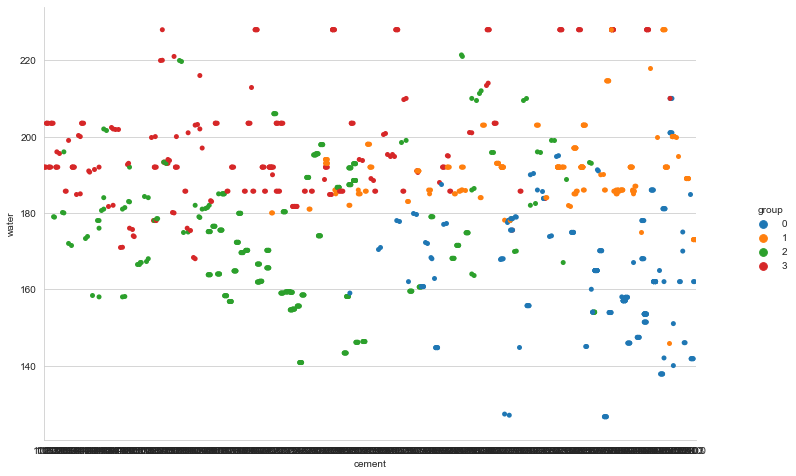

In [28]:
# Cement and water distribution - across various groups

g=sns.catplot(x='cement',y='water',hue ='group',kind='swarm',data=mydata_clustered)
sns.despine()
plt.gcf().set_size_inches(12, 7)

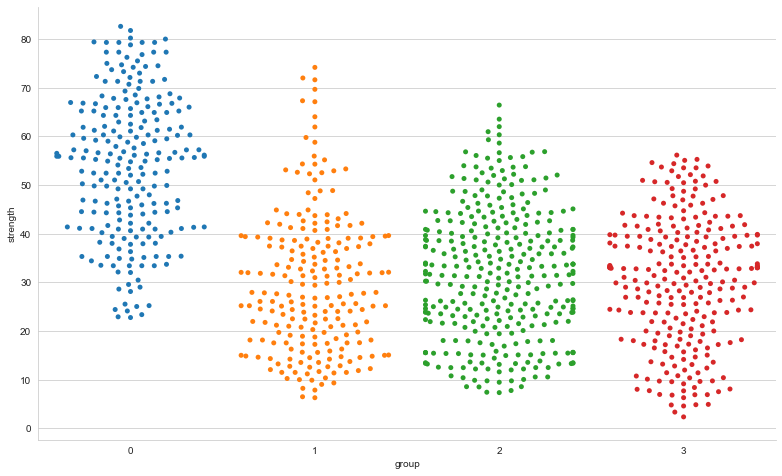

In [29]:
# Strength distribution - across various groups

g=sns.catplot(x='group',y='strength',kind='swarm',data=mydata_clustered)
sns.despine()
plt.gcf().set_size_inches(12, 7)

In [30]:
# Creating cluster using Gaussian Mixture approach

gmm = GaussianMixture(n_components=3,random_state =9)
gmm.fit(mydata_z)
labels = gmm.predict(mydata_z)
counts = np.bincount(labels[labels>=0])
print(counts)

[373 303 354]


In [31]:
mydata_clustered_gmm = mydata.copy(deep= True)
mydata_clustered_gmm["group"] = labels
mydata_clustered_gmm['group'] = mydata_clustered_gmm['group'].astype('category')
mydata_clustered_gmm.group.value_counts()

0    373
2    354
1    303
Name: group, dtype: int64

In [32]:
mydata_clustered_gmm.head(5)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,group
0,141.3,5.361292,0.0,203.5,0.000000,971.8,748.5,3.367296,29.89,0
1,168.9,3.765840,124.3,158.3,2.468100,1080.8,796.2,2.708050,23.51,2
2,250.0,0.000000,95.7,187.4,1.871802,956.9,861.2,3.367296,29.22,2
3,266.0,4.744932,0.0,228.0,0.000000,932.0,670.0,3.367296,45.85,0
4,154.8,5.217107,0.0,193.3,2.312535,1047.4,696.7,3.367296,18.29,1


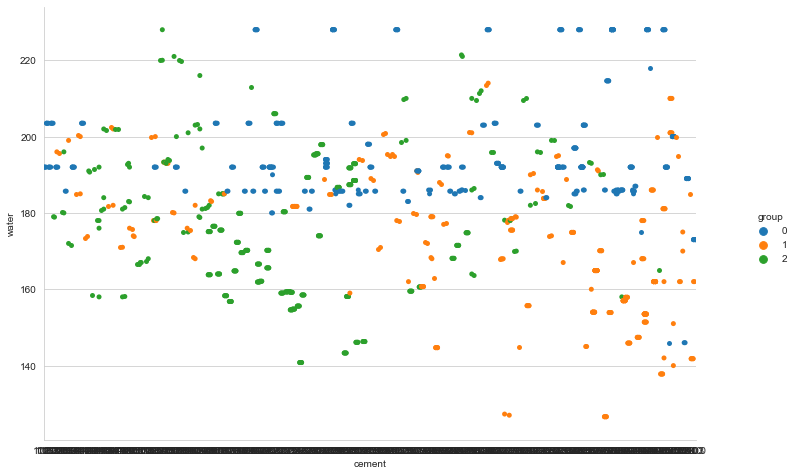

In [33]:
# Cement and water distribution - across various groups
g=sns.catplot(x='cement',y='water',hue ='group',kind='swarm',data=mydata_clustered_gmm)
sns.despine()
plt.gcf().set_size_inches(12, 7)

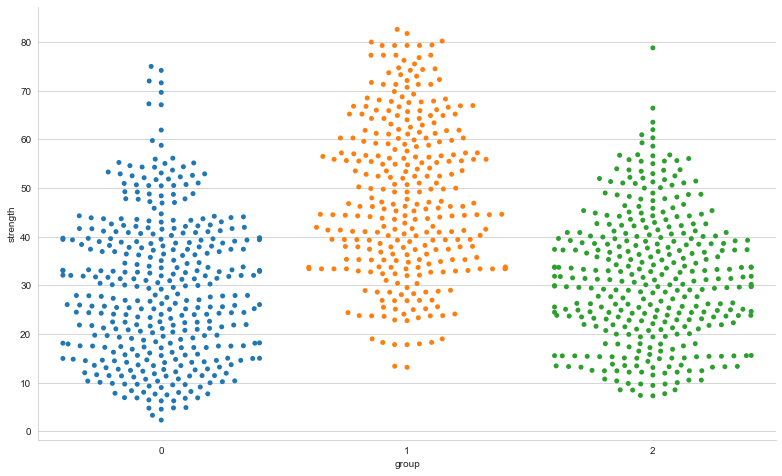

In [34]:
# Strength distribution - across various groups
g=sns.catplot(x='group',y='strength',kind='swarm',data=mydata_clustered_gmm)
sns.despine()
plt.gcf().set_size_inches(12, 7)

## 4. Feature Selection 

In [35]:
# Using OLS for feature selection

tind=len(mydata.columns)-1
array=mydata.values
X=array[:,0:tind]
y=array[:,[tind]]
#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)
#computing P value of features and coeff for features using statmodel logistic regression
model = sm.OLS(y_train,X_train)
result= model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.966    
Dependent Variable:     y                AIC:                         4931.8519
Date:                   2019-11-09 16:20 BIC:                         4968.4970
No. Observations:       721              Log-Likelihood:              -2457.9  
Df Model:               8                F-statistic:                 2525.    
Df Residuals:           713              Prob (F-statistic):          0.00     
R-squared (uncentered): 0.966            Scale:                       54.130   
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0905        0.0033       27.7632      0.0000       0.0841       0.0969
x2          2.3856        0.1453       16.4200      0.0000       2.1003       2.6708
x3          0.0152        0.0072        2.1036      0.0358       0.0010       0.0294
x4         -0.2071        0.0136      -15.2237      0.0000      -0.2338      -0.1804
x5          2.4942        0.4181        5.9656      0.0000       1.6734       3.3151
x6          0.0101        0.0026        3.8286      0.0001       0.0049       0.0153
x7         -0.0021        0.0029       -0.7166      0.4739      -0.0078       0.0036
x8          9.0504        0.2554       35.4328      0.0000       8.5490       9.5519
-------------------------------------------------------------------------------
Omnibus:                  14.500            Durbin-Watson:               2.007 
Prob(Omnibus):            0.001             Jarque-Bera (JB):            16.538
Skew:                     0.270             Prob(JB):                    0.000 
Kurtosis:                 3.508             Condition No.:               2016  
===============================================================================
* The condition number is large (2e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [36]:

LRSMpvalue = pd.DataFrame(result.pvalues)
features = pd.DataFrame(mydata.columns)
LRSMFeatureScore = pd.concat([features,LRSMpvalue],axis=1)
LRSMFeatureScore.columns = ['Feature','P Value']
LRSMFeatureScore.head(10).round(2)

,Feature,P Value
0,cement,0.00
1,slag,0.00
2,ash,0.04
3,water,0.00
4,superplastic,0.00
5,coarseagg,0.00
6,fineagg,0.47
7,age,0.00
8,strength,NaN


In [37]:
flist_ols = list(LRSMFeatureScore.Feature[LRSMFeatureScore['P Value']<0.05])
print()
print('List of features as per OLS:')
print()
print(flist_ols)


List of features as per OLS:

['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'age']


In [38]:
# Using RFE for feature selection

mydata_z = mydata.apply(zscore)
arrayX=mydata_z.values
arrayy=mydata.values
tind=len(mydata_z.columns)-1
X=arrayX[:,0:tind]
y=arrayy[:,[tind]]
model = LinearRegression()
rfe = RFE(model,n_features_to_select =7)
rfe = rfe.fit(X,y.ravel())
rfesupport=pd.DataFrame(rfe.support_)
rferanking=pd.DataFrame(rfe.ranking_)
features=pd.DataFrame(mydata_z.columns)
RFEFeatureScore=pd.concat([features,rfesupport,rferanking],axis=1)
RFEFeatureScore.columns=['Feature','Support','Ranking']
RFEFeatureScore.sort_values(by='Ranking')

,Feature,Support,Ranking
0,cement,True,1.0
1,slag,True,1.0
2,ash,True,1.0
3,water,True,1.0
4,superplastic,True,1.0
6,fineagg,True,1.0
7,age,True,1.0
5,coarseagg,False,2.0
8,strength,NaN,NaN


In [39]:
flist_rfe = RFEFeatureScore['Feature'][RFEFeatureScore.Support==True].tolist()
print('List of features as per RFE:')
print()
print(flist_rfe)

List of features as per RFE:

['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'age']


In [40]:
# Using Stepforward selection method to select features

s= mydata
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)
 

# Train and test the model

seed = 9
n_jobs=4
pre_dispatch=8
#scoring='accuracy'
cv=5

model = LinearRegression(n_jobs=n_jobs)

# model build

sfs1 = sfs(model,k_features=7,forward=True,floating=False,verbose=0,cv=cv,n_jobs=n_jobs)
sfs1 = sfs1.fit(X_train, y_train)

feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

col_list = list(mydata.columns)
flist_sfs = [col_list[i] for i in feat_cols]
print()
print('List of features as per SFS:')
print()
print(flist_sfs)

[0, 1, 3, 4, 5, 6, 7]

List of features as per SFS:

['cement', 'slag', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']


In [41]:
# Using Decision Tree for feature importance identification 

s= mydata
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]

8
#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)


# Train and test the model


seed = 9

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
colm=np.array(mydata.columns[0:-1])
df_fimp=pd.DataFrame(np.array([model.feature_importances_]),columns=colm)
df_fimp.sort_values(ascending=False,by=0,axis=1).transpose().round(2)

,0
age,0.35
cement,0.24
water,0.20
slag,0.08
ash,0.05
fineagg,0.03
superplastic,0.03
coarseagg,0.02


In [42]:
df_temp = df_fimp[df_fimp>0.03].dropna(axis=1)
df_temp.head(10)
flist_dt = list(df_temp.columns)
print('List of features as per DT:')
print()
print(flist_dt)

List of features as per DT:

['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'age']


In [43]:
# dataframe to compare the selection of features under various methods
 
collist = mydata.columns.tolist()
collist.remove('strength')
collist.sort
df_features = pd.DataFrame()
df_features['Features'] = collist

for rlist in flist_rfe:
    df_features['RFE'] = df_features['Features'].apply(lambda x : 'Yes' if  ( x in  flist_rfe) else '' )
    ;

for sfslist in flist_sfs:
    df_features['SFS'] = df_features['Features'].apply(lambda x : 'Yes' if  ( x in  flist_sfs) else '' )
    ;

for olslist in flist_ols:
    df_features['OLS'] = df_features['Features'].apply(lambda x : 'Yes' if  ( x in  flist_ols) else '' )
    ("")  

for dtlist in flist_dt:
    df_features['DT'] = df_features['Features'].apply(lambda x : 'Yes' if  ( x in  flist_dt) else '' )
    ;      
    
df_features['RFE'].replace('', np.nan, inplace=True)
df_features['DT'].replace('', np.nan, inplace=True)
df_features['SFS'].replace('', np.nan, inplace=True)
df_features['OLS'].replace('', np.nan, inplace=True)
df_features.dropna(thresh=2, inplace=True)
df_features['RFE'].replace(np.nan,'', inplace=True)
df_features['DT'].replace(np.nan,'',inplace=True)
df_features['SFS'].replace(np.nan,'',inplace=True)
df_features['OLS'].replace(np.nan,'',inplace=True)

df_features.head(20)

,Features,RFE,SFS,OLS,DT
0,cement,Yes,Yes,Yes,Yes
1,slag,Yes,Yes,Yes,Yes
2,ash,Yes,,Yes,Yes
3,water,Yes,Yes,Yes,Yes
4,superplastic,Yes,Yes,Yes,Yes
5,coarseagg,,Yes,Yes,
6,fineagg,Yes,Yes,,Yes
7,age,Yes,Yes,Yes,Yes


#1.The above is a comparison of 7 features selected by various approach.
#2.As we can see, feature list selected is different in each one of the approaches. 
#3.There are some features that are selected in all approaches.

Number of features for > .95 level is: 6



For number of components = 1,  percentage variance explained = 27.61
For number of components = 2,  percentage variance explained = 46.00
For number of components = 3,  percentage variance explained = 61.85
For number of components = 4,  percentage variance explained = 75.01
For number of components = 5,  percentage variance explained = 87.35
For number of components = 6,  percentage variance explained = 97.13



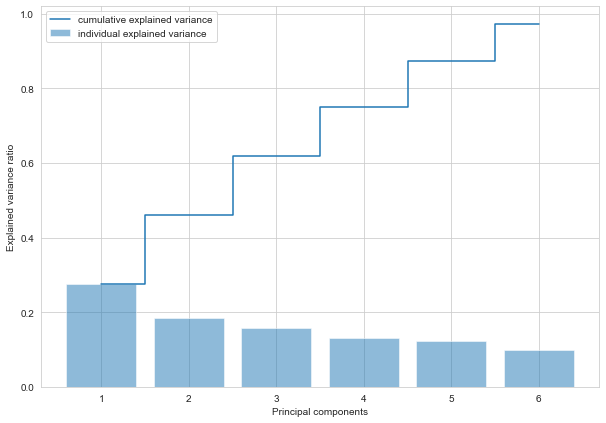

In [44]:
# Using PCA for checking spread of features for 95% variance explanation

s= mydata
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]

# Feature Scaling
sc= StandardScaler()
X_std= sc.fit_transform(X)


pca = PCA(.95)
X_std = pca.fit_transform(X_std)
explained_variance = pca.explained_variance_ratio_
print("Number of features for > .95 level is: %s" % pca.n_components_)
print()
print()
plt.bar(range(1,7), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7),np.cumsum(pca.explained_variance_ratio_), where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.gcf().set_size_inches(10, 7)
print()
exp_var_cumsum=pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100)  
for index,var in enumerate(exp_var_cumsum):  
    print('For number of components = %d,  percentage variance explained = %1.2f' %(index+1,np.round(var,2)))
    ;
print()

In [45]:
# Creating composite feature

mydata2=mydata.copy(deep=True)
mydata2['fine_coarseagg_ratio'] = rawdata.fineagg/rawdata.coarseagg
mydata2.drop('fineagg',axis=1,inplace=True)
mydata2.drop('coarseagg',axis=1,inplace=True)
mydata2.sample(5)

,cement,slag,ash,water,superplastic,age,strength,fine_coarseagg_ratio
203,231.8,0.000000,121.6,174.0,2.041220,4.615121,45.84,0.736937
334,323.7,5.648270,0.0,183.8,2.424803,1.386294,28.30,0.700011
623,380.0,0.000000,0.0,228.0,0.000000,5.602119,53.30,0.718884
172,212.1,0.000000,121.6,180.3,1.902108,1.386294,12.47,0.736857
23,132.0,5.337538,161.0,179.0,1.791759,3.367296,33.30,0.848904


In [46]:
# rearranging the columns to keep target variable as last column
col_order = ('cement', 'slag', 'ash', 'water', 'superplastic', 'age','fine_coarseagg_ratio', 'strength')
mydata2 = mydata2[list(col_order)]
mydata2.sample(5)

,cement,slag,ash,water,superplastic,age,fine_coarseagg_ratio,strength
255,322.0,0.000000,0.0,203.0,0.000000,2.708050,0.821355,20.77
33,313.0,4.983607,0.0,127.0,2.197225,3.367296,0.822000,44.52
436,446.0,3.218876,79.0,162.0,2.424803,3.367296,0.736298,53.39
584,375.0,4.551769,0.0,126.6,3.194583,4.043051,1.164887,60.20
346,298.0,4.927254,107.0,201.0,1.945910,3.367296,0.746014,53.52


For the purpose of evaluation various data combinations are created as follows

In [47]:
# mydata - data with all features

# mydata2 - data with 2 features dropped and 1 new composite feature created

# mydata_rfe - data with features as per RFE method
mydata_rfe = mydata[flist_rfe].copy(deep=True)
mydata_rfe['strength'] = mydata['strength'].copy(deep=True)

# mydata_ols- data with features as per OLS method
mydata_ols = mydata[flist_ols].copy(deep=True)
mydata_ols['strength'] = mydata['strength'].copy(deep=True)

# mydata_sfs- data with features as per SFS method
mydata_sfs = mydata[flist_sfs].copy(deep=True)
mydata_sfs['strength'] = mydata['strength'].copy(deep=True)

# mydata_dt- data with features as per ST method
mydata_dt = mydata[flist_dt].copy(deep=True)
mydata_dt['strength'] = mydata['strength'].copy(deep=True)

# mydata_g0- data with all features but data pertaining to group 0 only
mydata_g0 = mydata_clustered[mydata_clustered.group==0].copy(deep=True)
mydata_g0 = mydata_g0.drop('group',axis=1)

# mydata_g1- data with all features but data pertaining to group 1 only
mydata_g1 = mydata_clustered[mydata_clustered.group==1].copy(deep=True)
mydata_g1 = mydata_g1.drop('group',axis=1)

# mydata_g2-data with all features but data pertaining to group 2 only
mydata_g2 = mydata_clustered[mydata_clustered.group==2].copy(deep=True)
mydata_g2 = mydata_g2.drop('group',axis=1)

# mydata_g3-data with all features but data pertaining to group 3 only
mydata_g3 = mydata_clustered[mydata_clustered.group==3].copy(deep=True)
mydata_g3 = mydata_g3.drop('group',axis=1)

# mydata_gmm_g0- data with all features but data pertaining to group 0 only
mydata_gmm_g0 = mydata_clustered_gmm[mydata_clustered_gmm.group==0].copy(deep=True)
mydata_gmm_g0 = mydata_gmm_g0.drop('group',axis=1)

# mydata_gmm_g1- data with all features but data pertaining to group 1 only
mydata_gmm_g1 = mydata_clustered_gmm[mydata_clustered_gmm.group==1].copy(deep=True)
mydata_gmm_g1 = mydata_gmm_g1.drop('group',axis=1)

# mydata_gmm_g2-data with all features but data pertaining to group 2 only
mydata_gmm_g2 = mydata_clustered_gmm[mydata_clustered_gmm.group==2].copy(deep=True)
mydata_gmm_g2 = mydata_gmm_g2.drop('group',axis=1)




## 5. Model Building and Evaluation

In [48]:
# Common parameter variables

seed = 9
n_jobs=4
pre_dispatch=8
scoring='r2'
scoring_gs = 'neg_mean_squared_error'
cv=5

### 5.1 Model evaluation without hyper parameter tuning

In [49]:
# Model comparison for all data source variants

dflist= [mydata,mydata2,mydata_rfe,mydata_ols,mydata_sfs,mydata_dt,mydata_g0,mydata_g1,mydata_g2,mydata_g3,mydata_gmm_g0,mydata_gmm_g1,mydata_gmm_g2]

counter = 0
for s in dflist:
    #print('Counter:',counter)
    tind=len(s.columns)-1
    array=s.values
    X=array[:,0:tind]
    y=array[:,[tind]]
    
    # polinomial feature generation

    poly2 = PolynomialFeatures( degree = 2, include_bias = False)    
    X_p2 = poly2.fit_transform(X)
    poly3 = PolynomialFeatures( degree = 3, include_bias = False) 
    X_p3 = poly3.fit_transform(X)    
    
    #creating train test split

    X_train,X_test,X_p2_train,X_p2_test,X_p3_train,X_p3_test,y_train,y_test= train_test_split(X,X_p2,X_p3,y,test_size=0.3,random_state=9)
    

    # Feature Scaling
    sc= StandardScaler()
    X_train= sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_p2_train= sc.fit_transform(X_p2_train)
    X_p2_test = sc.transform(X_p2_test)
    X_p3_train= sc.fit_transform(X_p3_train)
    X_p3_test = sc.transform(X_p3_test)     

    X_train_o = X_train
    X_test_o = X_test
    X_o = X


    if counter == 0:
        variant= 'All Features'
        featnum = 8
    elif counter == 1:
        variant= 'Composite Feature'
        featnum = 7
    elif counter == 2:
        variant= 'Features-RFE'
        featnum = 7
    elif counter == 3:
        variant= 'Features-OLS'
        featnum = 7
    elif counter == 4:
        variant= 'Features-SFS'
        featnum = 7
    elif counter == 5:
        variant= 'Features-DT'
        featnum = 7
    elif counter == 6:
        variant= 'Cluster 0'
        featnum = 8
    elif counter == 7:
        variant= 'Cluster 1'
        featnum = 8
    elif counter == 8:
        variant= 'Cluster 2'
        featnum = 8
    elif counter == 9:
        variant= 'Cluster 3'
        featnum = 8
    elif counter == 10:
        variant= 'GMM Cluster 0'
        featnum = 8
    elif counter == 11:
        variant= 'GMM Cluster 1'
        featnum = 8        
    else:
        variant= 'GMM Cluster 2'
        featnum = 8


    # Train and test the model

    start_time=time.time()

    mlist=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

    for m in mlist:
        start_time=time.time()
        if m == 0:
            model = LinearRegression()
            mname = model.__class__.__name__
        elif m == 1:
            model = Lasso(alpha=1)
            mname = model.__class__.__name__
        elif m == 2:
            model= Ridge(alpha=1)
            mname = model.__class__.__name__
        elif m == 3:
            model= ElasticNet(alpha=1)
            mname = model.__class__.__name__
        elif m == 4:
            model= SVR(kernel="rbf")
            mname = model.__class__.__name__             
        elif m == 5 and counter <=5:
            model= KernelRidge(kernel='polynomial', degree=3)
            mname = model.__class__.__name__               
        elif m == 6 and counter <=5 :
            X_train = X_p2_train
            X_test = X_p2_test
            X = X_p2
            model = LinearRegression()
            mname = 'LR-Polynomial-2'
        elif m == 7 and counter <=5 :
            X_train = X_p2_train
            X_test = X_p2_test
            X = X_p2
            model = Lasso()
            mname = 'Lasso-Polynomial-2'
        elif m == 8 and counter <=5 :
            X_train = X_p2_train
            X_test = X_p2_test
            X = X_p2
            model = Ridge()
            mname = 'Ridge-Polynomial-2'
        elif m == 9 and counter <=5 :
            X_train = X_p3_train
            X_test = X_p3_test
            X = X_p3
            model = LinearRegression()
            mname = 'LR-Polynomial-3'
        elif m == 10 and counter <=5 :
            X_train = X_p3_train
            X_test = X_p3_test
            X = X_p3
            model = Lasso()
            mname = 'Lasso-Polynomial-3'
        elif m == 11 and counter <=5 :
            X_train = X_p3_train
            X_test = X_p3_test
            X = X_p3
            model = Ridge()
            mname = 'Ridge-Polynomial-3'
        elif m == 12:
            X_train = X_train_o
            X_test = X_test_o
            X = X_o
            model= KNeighborsRegressor(n_neighbors=5,weights = 'distance')
            mname = model.__class__.__name__
        elif m == 13:
            model= AdaBoostRegressor(random_state=seed)
            mname = model.__class__.__name__
        elif m == 14:
            model = ExtraTreesRegressor(random_state=seed)
            mname = model.__class__.__name__
        elif m == 15:
            model = DecisionTreeRegressor(random_state=seed)
            mname = model.__class__.__name__
        elif m == 16:
            model = RandomForestRegressor(random_state=seed)
            mname = model.__class__.__name__
        elif m == 17:
            model = GradientBoostingRegressor(random_state=seed)
            mname = model.__class__.__name__
        elif m == 18:
            model = XGBRegressor(objective='reg:squarederror',random_state=seed)
            mname = model.__class__.__name__
        else:
            pass

        model.fit(X_train, y_train.ravel())
        y_predict = model.predict(X_test)

        if (0 <= m <= 3) and counter == 0:

            paramoutput  = {'Model':mname,
                          'Variant':variant,
                          'No.of features':featnum,
                          'Type':'Base',
                          'Intercept':model.intercept_,
                          'Coeff_cement':model.coef_[0],
                          'Coeff_slag':model.coef_[1],
                          'Coeff_ash':model.coef_[2],
                          'Coeff_water':model.coef_[3],
                          'Coeff_superplastic':model.coef_[4],
                          'Coeff_coarseagg':model.coef_[5],
                          'Coeff_fineagg':model.coef_[6],
                          'Coeff_age':model.coef_[7],

                         }


            paramcompdf = paramcompdf.append(paramoutput,ignore_index=True)


        elif (13 <= m <= 18) and counter == 0:


            fioutput  = {'Model':mname,
                          'Variant':variant,
                          'No.of features':featnum,
                          'Type':'Base',
                          'cement':model.feature_importances_[0],
                          'slag':model.feature_importances_[1],
                          'ash':model.feature_importances_[2],
                          'water':model.feature_importances_[3],
                          'superplastic':model.feature_importances_[4],
                          'coarseagg':model.feature_importances_[5],
                          'fineagg':model.feature_importances_[6],
                          'age':model.feature_importances_[7],

                         }


            ficompdf = ficompdf.append(fioutput,ignore_index=True)

        else:
             pass        

        # Model evaluation

        r2Score_train = np.round(model.score(X_train, y_train),2)
        r2Score = np.round(metrics.r2_score(y_test, y_predict),2)
        mse=metrics.mean_squared_error(y_test, y_predict)
        rmse =np.round(sqrt(mse),2)

        #cross validation score on full data set
        cv_score_base = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,scoring =scoring,pre_dispatch=pre_dispatch)
        cv_score = np.round(cv_score_base.mean(),2)
        cv_score_sd = np.round(cv_score_base.std(),2)
        cv_range =np.round(cv_score_base.mean()- 2*cv_score_base.std(),2) ,'to', np.round(cv_score_base.mean()+ 2*cv_score_base.std(),2)

        et=round(time.time()-start_time,2)


        if m in (5,6,7,8,9,10,11) and counter in (6,7,8,9,10,11,12):
            pass
        else:

            # Updating model evaluation output dataframe

            print(mname +' on '+ variant + '  completed in',et, 'seconds')

            smodeloutput = {'Model':mname,
                              'Variant':variant,
                              'No.of features':featnum,
                              'Type':'Base',
                              'R2_Train':r2Score_train,
                              'R2':r2Score,
                              'RMSE':rmse,
                              'R2:CV Mean':cv_score,
                              'R2:Range @95% CL':cv_range
                             }


            scompdf = scompdf.append(smodeloutput,ignore_index=True)

        ;
    counter = counter+1

    ;



LinearRegression on All Features  completed in 0.06 seconds
Lasso on All Features  completed in 0.04 seconds
Ridge on All Features  completed in 0.04 seconds
ElasticNet on All Features  completed in 0.03 seconds
SVR on All Features  completed in 0.21 seconds
KernelRidge on All Features  completed in 1.92 seconds
LR-Polynomial-2 on All Features  completed in 0.03 seconds
Lasso-Polynomial-2 on All Features  completed in 0.09 seconds
Ridge-Polynomial-2 on All Features  completed in 0.02 seconds
LR-Polynomial-3 on All Features  completed in 0.07 seconds
Lasso-Polynomial-3 on All Features  completed in 0.35 seconds
Ridge-Polynomial-3 on All Features  completed in 0.05 seconds
KNeighborsRegressor on All Features  completed in 0.06 seconds
AdaBoostRegressor on All Features  completed in 0.4 seconds
ExtraTreesRegressor on All Features  completed in 0.11 seconds
DecisionTreeRegressor on All Features  completed in 0.03 seconds
RandomForestRegressor on All Features  completed in 0.14 seconds
Grad

In [50]:
scompdf[scompdf['Variant'].isin(['All Features', 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3','GMM Cluster 0','GMM Cluster 1','GMM Cluster 2'])]\
                          .pivot(index='Model',columns='Variant',values='R2').round(2).dropna()


Variant,All Features,Cluster 0,Cluster 1,Cluster 2,Cluster 3,GMM Cluster 0,GMM Cluster 1,GMM Cluster 2
Model,,,,,,,,
AdaBoostRegressor,0.81,0.56,0.89,0.83,0.75,0.86,0.76,0.71
DecisionTreeRegressor,0.85,0.66,0.85,0.77,0.70,0.88,0.72,0.49
ElasticNet,0.69,0.42,0.79,0.59,0.54,0.69,0.51,0.62
ExtraTreesRegressor,0.90,0.62,0.94,0.85,0.77,0.95,0.81,0.78
GradientBoostingRegressor,0.91,0.69,0.94,0.94,0.83,0.94,0.84,0.84
KNeighborsRegressor,0.89,0.68,0.89,0.80,0.78,0.94,0.81,0.78
Lasso,0.80,0.46,0.87,0.73,0.58,0.79,0.66,0.78
LinearRegression,0.81,0.41,0.86,0.83,0.67,0.86,0.71,0.86
RandomForestRegressor,0.90,0.67,0.93,0.87,0.75,0.88,0.80,0.75


#### Based on the above we can infer the following 
#1. K means based cluster ( columns: Cluster 0, Cluster 1, Cluster 2, Cluster 3) and GaussianMixture based cluster ( GMM Cluster 0,GMM Cluster 1,GMM Cluster 2) results are compared with integrated model ('All Features)(based on R2 score).
#2. XGB and Gradiant Boost gives superior rating ( based on R2 score).
#3. As regards clusters based on K means, only 2 out of 4 clusters perform better than integrated model. Cluster 0 performs the worst. Hence k means cluster cannot be used for further model evaluation and analysis.
#4. As regards clusters based on GaussianMixure, only 1 cluster perform better than integrated model. Hence GaussianMixture cluster cannot be used for further model evaluation and analysis.



In [51]:
modellist1 = ('Lasso', 'Lasso-Polynomial-2', 'Lasso-Polynomial-3',\
             'Ridge', 'Ridge-Polynomial-2', 'Ridge-Polynomial-3',\
             'LinearRegression', 'LR-Polynomial-2', 'LR-Polynomial-3',\
             'KernelRidge')

variantlist1 = ('All Features','Composite Feature', 'Features-RFE', 'Features-OLS', 'Features-SFS', 'Features-DT')
scompdf_temp = scompdf[scompdf['Model'].isin (modellist1) ]
scompdf_temp[scompdf_temp['Variant'].isin(variantlist1) ].pivot(index='Model',columns='Variant',values='R2').round(2).dropna()

Variant,All Features,Composite Feature,Features-DT,Features-OLS,Features-RFE,Features-SFS
Model,,,,,,
KernelRidge,0.91,0.90,0.90,0.90,0.90,0.89
LR-Polynomial-2,0.88,0.87,0.87,0.87,0.87,0.86
LR-Polynomial-3,0.88,0.89,0.88,0.89,0.88,0.88
Lasso,0.80,0.80,0.80,0.80,0.80,0.80
Lasso-Polynomial-2,0.80,0.81,0.80,0.81,0.80,0.80
Lasso-Polynomial-3,0.80,0.81,0.80,0.82,0.80,0.80
LinearRegression,0.81,0.82,0.81,0.82,0.81,0.81
Ridge,0.81,0.82,0.81,0.82,0.81,0.81
Ridge-Polynomial-2,0.88,0.87,0.86,0.87,0.86,0.86


#### Based on the above we can infer the following 
#1. Linear model and Polynomial model results are compared (based on R2 score).
#2. Polynomial models order 3 perform marginally better than polymonial models of order 2.
#3. Linear models underperform when compared to polynomial models.
#4. KernalRidge based polynomial model performs best among these models.
#5. Further models with 7 features perform very close to model with 8 features ('All Features).
#6. The above is based on models without tuning any hyper parameters. 

In [52]:
scompdf[scompdf.Variant.isin(variantlist1)].nlargest(10, 'R2')

,Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
5,KernelRidge,All Features,8,Base,0.93,0.91,5.12,0.87,"(0.81, to, 0.93)"
17,GradientBoostingRegressor,All Features,8,Base,0.95,0.91,5.05,0.90,"(0.87, to, 0.93)"
18,XGBRegressor,All Features,8,Base,0.95,0.91,5.13,0.90,"(0.87, to, 0.93)"
33,ExtraTreesRegressor,Composite Feature,7,Base,1.00,0.91,5.14,0.91,"(0.88, to, 0.95)"
36,GradientBoostingRegressor,Composite Feature,7,Base,0.95,0.91,4.95,0.90,"(0.87, to, 0.93)"
37,XGBRegressor,Composite Feature,7,Base,0.95,0.91,5.08,0.90,"(0.87, to, 0.93)"
55,GradientBoostingRegressor,Features-RFE,7,Base,0.95,0.91,5.05,0.90,"(0.87, to, 0.93)"
71,ExtraTreesRegressor,Features-OLS,7,Base,1.00,0.91,5.00,0.90,"(0.86, to, 0.95)"
74,GradientBoostingRegressor,Features-OLS,7,Base,0.95,0.91,5.12,0.90,"(0.86, to, 0.93)"
90,ExtraTreesRegressor,Features-SFS,7,Base,1.00,0.91,4.89,0.91,"(0.87, to, 0.95)"


#### Based on the above we can infer the following 
#1. KernelRidge ( on data with 8 features) perform better the rest based on R2 score.
#2. However cv mean score is very low for this.
#3. Highest R2 CV mean score is for ExtraTreeRegressor model .
#4. However SFS feature based  ExtraTreeRegressor model shows better R2 confidence range  , while RMSE is also the lowest.
#5. The above is based on models without tuning any hyper parameters.

In [53]:
scompdf[scompdf.Variant.isin(variantlist1)].nsmallest(10, 'RMSE')

,Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
90,ExtraTreesRegressor,Features-SFS,7,Base,1.00,0.91,4.89,0.91,"(0.87, to, 0.95)"
36,GradientBoostingRegressor,Composite Feature,7,Base,0.95,0.91,4.95,0.90,"(0.87, to, 0.93)"
71,ExtraTreesRegressor,Features-OLS,7,Base,1.00,0.91,5.00,0.90,"(0.86, to, 0.95)"
93,GradientBoostingRegressor,Features-SFS,7,Base,0.95,0.91,5.04,0.90,"(0.87, to, 0.93)"
17,GradientBoostingRegressor,All Features,8,Base,0.95,0.91,5.05,0.90,"(0.87, to, 0.93)"
55,GradientBoostingRegressor,Features-RFE,7,Base,0.95,0.91,5.05,0.90,"(0.87, to, 0.93)"
112,GradientBoostingRegressor,Features-DT,7,Base,0.95,0.91,5.05,0.90,"(0.87, to, 0.93)"
37,XGBRegressor,Composite Feature,7,Base,0.95,0.91,5.08,0.90,"(0.87, to, 0.93)"
5,KernelRidge,All Features,8,Base,0.93,0.91,5.12,0.87,"(0.81, to, 0.93)"
74,GradientBoostingRegressor,Features-OLS,7,Base,0.95,0.91,5.12,0.90,"(0.86, to, 0.93)"


#### Based on the above we can infer the following 
#1. ExtraTreeRegressor ( on 7 feature data set based on SFS) perform better the rest based on lowest RMSE score.
#2. R2 score confidence level range is also better than the rest.
#3. The above is based on models without tuning any hyper parameters.

### 5.2 Hyper parameter tuning 

In [54]:
# hyper parameter tuning for all data sources ( excluding cluster based split)

dflist2= [mydata,mydata2,mydata_rfe,mydata_ols,mydata_sfs,mydata_dt]

counter = 0
for s in dflist2:
    print('Counter:',counter)
    tind=len(s.columns)-1
    array=s.values
    X=array[:,0:tind]
    y=array[:,[tind]]

    # polinomial feature generation

    poly2 = PolynomialFeatures( degree = 2, include_bias = False)    
    X_p2 = poly2.fit_transform(X)
    poly3 = PolynomialFeatures( degree = 3, include_bias = False) 
    X_p3 = poly3.fit_transform(X)    
    
    #creating train test split

    X_train,X_test,X_p2_train,X_p2_test,X_p3_train,X_p3_test,y_train,y_test= train_test_split(X,X_p2,X_p3,y,test_size=0.3,random_state=9)
    

    # Feature Scaling
    sc= StandardScaler()
    X_train= sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_p2_train= sc.fit_transform(X_p2_train)
    X_p2_test = sc.transform(X_p2_test)
    X_p3_train= sc.fit_transform(X_p3_train)
    X_p3_test = sc.transform(X_p3_test)     

    X_train_o = X_train
    X_test_o = X_test
    X_o = X



    if counter == 0:
        variant= 'All Features'
        featnum = 8
    elif counter == 1:
        variant= 'Composite Feature'
        featnum = 7        
    elif counter == 2:
        variant= 'Features-RFE'
        featnum = 7        
    elif counter == 3:
        variant= 'Features-OLS'
        featnum = 7        
    elif counter == 4:
        variant= 'Features-SFS'
        featnum = 7        
    else:
        variant= 'Features-DT'
        featnum = 7        
        
    # Train and test the model

    start_time=time.time()

    mlist=[1,2,3,4,5,7,8,10,11,12,13,14,15,16,17,18]

    for m in mlist:
        start_time=time.time()
        if m == 1:
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10)}
            estimator=Lasso()
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 2:
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10)}
            estimator=Ridge()
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 3:
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10)}
            estimator=ElasticNet()
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 4:
            param_grid={'kernel':('poly','rbf'),'gamma':(0.001,0.0001),'C':(1,10)}
            estimator=SVR(kernel="rbf")
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__              
        elif m == 5:
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10),'degree':(2,3)}
            estimator=KernelRidge(kernel='polynomial')
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__          
        elif m == 7 :
            X_train = X_p2_train
            X_test = X_p2_test
            X = X_p2
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10)}
            estimator=Lasso(max_iter=4000)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = 'Lasso-Polynomial-2'
        elif m == 8 :
            X_train = X_p2_train
            X_test = X_p2_test
            X = X_p2
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10,15,20)}
            estimator=Ridge()
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = 'Ridge-Polynomial-2'
        elif m == 10 :
            X_train = X_p3_train
            X_test = X_p3_test
            X = X_p3
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10,15,20)}
            estimator=Lasso(max_iter=4000)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = 'Lasso-Polynomial-3'
        elif m == 11 :
            X_train = X_p3_train
            X_test = X_p3_test
            X = X_p3
            param_grid={'alpha':(1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10,15,20)}
            estimator=Ridge()
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = 'Ridge-Polynomial-3'
        elif m == 12:
            X_train = X_train_o
            X_test = X_test_o
            X = X_o
            param_grid={'n_neighbors':(3,5,7,9,11,13,15,17,19)}
            estimator=KNeighborsRegressor(weights = 'distance')
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 13:
            param_grid={'n_estimators':(50,75,100,150,200),'learning_rate':[0.0001,0.001,0.5, 0.8, 1.0]}
            estimator=AdaBoostRegressor(random_state=seed)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 14:
            param_grid={'n_estimators':(50,75,100,150,200,300,500,750,1000)}
            estimator=ExtraTreesRegressor(random_state=seed)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 15:
            param_grid={'max_depth':(10,15,20,25,30,40,50)}
            estimator=DecisionTreeRegressor(random_state=seed)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 16:
            param_grid={'n_estimators':(50,75,100,150,200)}
            estimator=RandomForestRegressor(random_state=seed)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        elif m == 17:
            param_grid={'n_estimators':(50,75,100,150,200,300,500,750,1000),'learning_rate':[0.0001,0.001,0.5, 0.8, 1.0]}
            estimator=GradientBoostingRegressor(random_state=seed)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__
        else:
            param_grid={'n_estimators':(50,75,100,150,200,300,500,750,1000,1250,1500),'learning_rate':[0.0001,0.001,0.5, 0.8, 1.0]}
            estimator=XGBRegressor(objective='reg:squarederror',random_state=seed)
            model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,scoring=scoring_gs,n_jobs=n_jobs,iid=False)
            mname = estimator.__class__.__name__


        model_gs.fit(X_train, y_train.ravel())
        y_predict = model_gs.predict(X_test)

        print()
        print('Best parameter for '+ mname + ' on ' + variant + ' is',model_gs.best_params_)

        
        model = model_gs.best_estimator_
        model.fit(X_train, y_train.ravel())
        y_predict = model.predict(X_test)
        
        if (0 <= m <= 3) and counter==0 :

            paramoutput  = {'Model':mname,
                          'Variant':variant,
                          'No.of features':featnum,
                          'Type':'Tuned',
                          'Intercept':model.intercept_,
                          'Coeff_cement':model.coef_[0],
                          'Coeff_slag':model.coef_[1],
                          'Coeff_ash':model.coef_[2],
                          'Coeff_water':model.coef_[3],
                          'Coeff_superplastic':model.coef_[4],
                          'Coeff_coarseagg':model.coef_[5],
                          'Coeff_fineagg':model.coef_[6],
                          'Coeff_age':model.coef_[7],

                         }


            paramcompdf = paramcompdf.append(paramoutput,ignore_index=True)


        elif (13 <= m <= 18) and counter==0 :


            fioutput  = {'Model':mname,
                          'Variant':variant,
                          'No.of features':featnum,
                          'Type':'Tuned',
                          'cement':model.feature_importances_[0],
                          'slag':model.feature_importances_[1],
                          'ash':model.feature_importances_[2],
                          'water':model.feature_importances_[3],
                          'superplastic':model.feature_importances_[4],
                          'coarseagg':model.feature_importances_[5],
                          'fineagg':model.feature_importances_[6],
                          'age':model.feature_importances_[7],

                         }


            ficompdf = ficompdf.append(fioutput,ignore_index=True)

        else:
             pass        

         # Model evaluation

        #r2Score_train = model.score(X_train, y_train)
        r2Score = np.round(metrics.r2_score(y_test, y_predict),2)
        mse=metrics.mean_squared_error(y_test, y_predict)
        rmse =np.round(sqrt(mse),2)

        #cross validation score on full data set
        cv_score_base = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,scoring =scoring,pre_dispatch=pre_dispatch)
        cv_score = np.round(cv_score_base.mean(),2)
        cv_score_sd = np.round(cv_score_base.std(),2)
        cv_range =np.round(cv_score_base.mean()- 2*cv_score_base.std(),2) , 'to' , np.round(cv_score_base.mean()+ 2*cv_score_base.std(),2)

        et=round(time.time()-start_time,2)

        # Updating model evaluation output dataframe

        
        print(mname +' tuning on '+ variant + '  completed in',et, 'seconds')
    

        smodeloutput = {'Model':mname,
                          'Variant':variant,
                          'No.of features':featnum,
                          'Type':'Tuned',
                          'R2_Train':'',
                          'R2':r2Score,
                          'RMSE':rmse,
                          'R2:CV Mean':cv_score,
                          'R2:Range @95% CL':cv_range
                         }


        scompdf = scompdf.append(smodeloutput,ignore_index=True)

        ;
    counter = counter+1

    ;

Counter: 0

Best parameter for Lasso on All Features is {'alpha': 0.001}
Lasso tuning on All Features  completed in 0.13 seconds

Best parameter for Ridge on All Features is {'alpha': 5}
Ridge tuning on All Features  completed in 0.1 seconds

Best parameter for ElasticNet on All Features is {'alpha': 0.01}
ElasticNet tuning on All Features  completed in 0.11 seconds

Best parameter for SVR on All Features is {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVR tuning on All Features  completed in 0.59 seconds

Best parameter for KernelRidge on All Features is {'alpha': 1, 'degree': 3}
KernelRidge tuning on All Features  completed in 3.15 seconds


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.06888601927494, tolerance: 20.108579561109575
  positive)
/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.06888601927494, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-2 on All Features is {'alpha': 0.01}
Lasso-Polynomial-2 tuning on All Features  completed in 2.02 seconds

Best parameter for Ridge-Polynomial-2 on All Features is {'alpha': 1}
Ridge-Polynomial-2 tuning on All Features  completed in 0.2 seconds


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 747.0292153966366, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-3 on All Features is {'alpha': 0.01}


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 747.0292153966366, tolerance: 20.108579561109575
  positive)


Lasso-Polynomial-3 tuning on All Features  completed in 8.55 seconds

Best parameter for Ridge-Polynomial-3 on All Features is {'alpha': 1}
Ridge-Polynomial-3 tuning on All Features  completed in 0.22 seconds

Best parameter for KNeighborsRegressor on All Features is {'n_neighbors': 3}
KNeighborsRegressor tuning on All Features  completed in 0.19 seconds

Best parameter for AdaBoostRegressor on All Features is {'learning_rate': 0.8, 'n_estimators': 200}
AdaBoostRegressor tuning on All Features  completed in 14.14 seconds

Best parameter for ExtraTreesRegressor on All Features is {'n_estimators': 1000}
ExtraTreesRegressor tuning on All Features  completed in 31.93 seconds

Best parameter for DecisionTreeRegressor on All Features is {'max_depth': 10}
DecisionTreeRegressor tuning on All Features  completed in 0.15 seconds

Best parameter for RandomForestRegressor on All Features is {'n_estimators': 200}
RandomForestRegressor tuning on All Features  completed in 6.24 seconds

Best paramete

/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4674.001469745201, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-3 on Composite Feature is {'alpha': 0.001}


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4674.001469745201, tolerance: 20.108579561109575
  positive)


Lasso-Polynomial-3 tuning on Composite Feature  completed in 4.69 seconds

Best parameter for Ridge-Polynomial-3 on Composite Feature is {'alpha': 1}
Ridge-Polynomial-3 tuning on Composite Feature  completed in 0.18 seconds

Best parameter for KNeighborsRegressor on Composite Feature is {'n_neighbors': 5}
KNeighborsRegressor tuning on Composite Feature  completed in 0.17 seconds

Best parameter for AdaBoostRegressor on Composite Feature is {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoostRegressor tuning on Composite Feature  completed in 16.38 seconds

Best parameter for ExtraTreesRegressor on Composite Feature is {'n_estimators': 200}
ExtraTreesRegressor tuning on Composite Feature  completed in 20.21 seconds

Best parameter for DecisionTreeRegressor on Composite Feature is {'max_depth': 20}
DecisionTreeRegressor tuning on Composite Feature  completed in 0.22 seconds

Best parameter for RandomForestRegressor on Composite Feature is {'n_estimators': 200}
RandomForestRegressor tunin

/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4370.51568939973, tolerance: 20.108579561109575
  positive)
/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4370.51568939973, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-2 on Features-RFE is {'alpha': 0.001}
Lasso-Polynomial-2 tuning on Features-RFE  completed in 2.89 seconds

Best parameter for Ridge-Polynomial-2 on Features-RFE is {'alpha': 0.01}
Ridge-Polynomial-2 tuning on Features-RFE  completed in 0.11 seconds


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5413.434884357328, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-3 on Features-RFE is {'alpha': 0.001}


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5413.434884357328, tolerance: 20.108579561109575
  positive)


Lasso-Polynomial-3 tuning on Features-RFE  completed in 4.71 seconds

Best parameter for Ridge-Polynomial-3 on Features-RFE is {'alpha': 1}
Ridge-Polynomial-3 tuning on Features-RFE  completed in 0.19 seconds

Best parameter for KNeighborsRegressor on Features-RFE is {'n_neighbors': 5}
KNeighborsRegressor tuning on Features-RFE  completed in 0.15 seconds

Best parameter for AdaBoostRegressor on Features-RFE is {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoostRegressor tuning on Features-RFE  completed in 12.78 seconds

Best parameter for ExtraTreesRegressor on Features-RFE is {'n_estimators': 500}
ExtraTreesRegressor tuning on Features-RFE  completed in 18.25 seconds

Best parameter for DecisionTreeRegressor on Features-RFE is {'max_depth': 20}
DecisionTreeRegressor tuning on Features-RFE  completed in 0.16 seconds

Best parameter for RandomForestRegressor on Features-RFE is {'n_estimators': 75}
RandomForestRegressor tuning on Features-RFE  completed in 3.9 seconds

Best parameter f

/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.666402207312785, tolerance: 20.108579561109575
  positive)
/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.666402207312785, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-2 on Features-OLS is {'alpha': 0.01}
Lasso-Polynomial-2 tuning on Features-OLS  completed in 1.45 seconds

Best parameter for Ridge-Polynomial-2 on Features-OLS is {'alpha': 1}
Ridge-Polynomial-2 tuning on Features-OLS  completed in 0.12 seconds


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.08116137475008, tolerance: 20.108579561109575
  positive)
/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.08116137475008, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-3 on Features-OLS is {'alpha': 0.01}
Lasso-Polynomial-3 tuning on Features-OLS  completed in 4.58 seconds

Best parameter for Ridge-Polynomial-3 on Features-OLS is {'alpha': 1}
Ridge-Polynomial-3 tuning on Features-OLS  completed in 0.21 seconds

Best parameter for KNeighborsRegressor on Features-OLS is {'n_neighbors': 5}
KNeighborsRegressor tuning on Features-OLS  completed in 0.17 seconds

Best parameter for AdaBoostRegressor on Features-OLS is {'learning_rate': 1.0, 'n_estimators': 100}
AdaBoostRegressor tuning on Features-OLS  completed in 10.63 seconds

Best parameter for ExtraTreesRegressor on Features-OLS is {'n_estimators': 75}
ExtraTreesRegressor tuning on Features-OLS  completed in 12.04 seconds

Best parameter for DecisionTreeRegressor on Features-OLS is {'max_depth': 10}
DecisionTreeRegressor tuning on Features-OLS  completed in 0.13 seconds

Best parameter for RandomForestRegressor on Features-OLS is {'n_estimators': 200}
RandomForestRe

/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7323.392256349542, tolerance: 20.108579561109575
  positive)
/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7323.392256349542, tolerance: 20.108579561109575
  positive)



Best parameter for Ridge on Features-SFS is {'alpha': 5}
Ridge tuning on Features-SFS  completed in 0.09 seconds

Best parameter for ElasticNet on Features-SFS is {'alpha': 0.01}
ElasticNet tuning on Features-SFS  completed in 0.13 seconds

Best parameter for SVR on Features-SFS is {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVR tuning on Features-SFS  completed in 0.77 seconds


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Best parameter for KernelRidge on Features-SFS is {'alpha': 1, 'degree': 3}


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KernelRidge tuning on Features-SFS  completed in 3.73 seconds

Best parameter for Lasso-Polynomial-2 on Features-SFS is {'alpha': 0.01}
Lasso-Polynomial-2 tuning on Features-SFS  completed in 2.09 seconds

Best parameter for Ridge-Polynomial-2 on Features-SFS is {'alpha': 1}
Ridge-Polynomial-2 tuning on Features-SFS  completed in 0.12 seconds


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6136.301887056477, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-3 on Features-SFS is {'alpha': 0.001}


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6136.301887056477, tolerance: 20.108579561109575
  positive)


Lasso-Polynomial-3 tuning on Features-SFS  completed in 5.8 seconds

Best parameter for Ridge-Polynomial-3 on Features-SFS is {'alpha': 0.01}
Ridge-Polynomial-3 tuning on Features-SFS  completed in 0.3 seconds

Best parameter for KNeighborsRegressor on Features-SFS is {'n_neighbors': 5}
KNeighborsRegressor tuning on Features-SFS  completed in 0.21 seconds

Best parameter for AdaBoostRegressor on Features-SFS is {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoostRegressor tuning on Features-SFS  completed in 13.37 seconds

Best parameter for ExtraTreesRegressor on Features-SFS is {'n_estimators': 100}
ExtraTreesRegressor tuning on Features-SFS  completed in 16.33 seconds

Best parameter for DecisionTreeRegressor on Features-SFS is {'max_depth': 10}
DecisionTreeRegressor tuning on Features-SFS  completed in 0.14 seconds

Best parameter for RandomForestRegressor on Features-SFS is {'n_estimators': 200}
RandomForestRegressor tuning on Features-SFS  completed in 6.05 seconds

Best paramete

/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4370.51568939973, tolerance: 20.108579561109575
  positive)
/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4370.51568939973, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-2 on Features-DT is {'alpha': 0.001}
Lasso-Polynomial-2 tuning on Features-DT  completed in 1.46 seconds

Best parameter for Ridge-Polynomial-2 on Features-DT is {'alpha': 0.01}
Ridge-Polynomial-2 tuning on Features-DT  completed in 0.11 seconds


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5413.434884357328, tolerance: 20.108579561109575
  positive)



Best parameter for Lasso-Polynomial-3 on Features-DT is {'alpha': 0.001}


/Users/sridharkrishnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5413.434884357328, tolerance: 20.108579561109575
  positive)


Lasso-Polynomial-3 tuning on Features-DT  completed in 4.72 seconds

Best parameter for Ridge-Polynomial-3 on Features-DT is {'alpha': 1}
Ridge-Polynomial-3 tuning on Features-DT  completed in 0.17 seconds

Best parameter for KNeighborsRegressor on Features-DT is {'n_neighbors': 5}
KNeighborsRegressor tuning on Features-DT  completed in 0.15 seconds

Best parameter for AdaBoostRegressor on Features-DT is {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoostRegressor tuning on Features-DT  completed in 12.18 seconds

Best parameter for ExtraTreesRegressor on Features-DT is {'n_estimators': 500}
ExtraTreesRegressor tuning on Features-DT  completed in 15.89 seconds

Best parameter for DecisionTreeRegressor on Features-DT is {'max_depth': 20}
DecisionTreeRegressor tuning on Features-DT  completed in 0.14 seconds

Best parameter for RandomForestRegressor on Features-DT is {'n_estimators': 75}
RandomForestRegressor tuning on Features-DT  completed in 3.77 seconds

Best parameter for GradientB

In [55]:
scompdf[scompdf.Variant.isin(variantlist1)].nlargest(10, 'R2')

,Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
212,GradientBoostingRegressor,All Features,8,Tuned,,0.93,4.57,0.92,"(0.89, to, 0.96)"
244,GradientBoostingRegressor,Features-RFE,7,Tuned,,0.93,4.52,0.92,"(0.89, to, 0.96)"
245,XGBRegressor,Features-RFE,7,Tuned,,0.93,4.51,0.93,"(0.9, to, 0.95)"
261,XGBRegressor,Features-OLS,7,Tuned,,0.93,4.53,0.93,"(0.9, to, 0.96)"
277,XGBRegressor,Features-SFS,7,Tuned,,0.93,4.53,0.93,"(0.9, to, 0.95)"
292,GradientBoostingRegressor,Features-DT,7,Tuned,,0.93,4.52,0.92,"(0.89, to, 0.96)"
293,XGBRegressor,Features-DT,7,Tuned,,0.93,4.51,0.93,"(0.9, to, 0.95)"
209,ExtraTreesRegressor,All Features,8,Tuned,,0.92,4.77,0.92,"(0.88, to, 0.96)"
211,RandomForestRegressor,All Features,8,Tuned,,0.92,4.80,0.91,"(0.88, to, 0.95)"
213,XGBRegressor,All Features,8,Tuned,,0.92,4.69,0.93,"(0.91, to, 0.96)"


#### Based on the above we can infer the following 
#1. GradientBoostingRegressor ( on data with 8 features) perform better the rest based on R2 score.
#2. However cv mean score is not the highest.
#3. Highest R2 CV mean score is for XGBRegressor models.
#4. RFE/DT feature based on XGBRegressor model shows better R2 confidence range , while RMSE is also the lowest.
#5. The above is based on models after tuning hyper parameters.

In [56]:
scompdf[scompdf.Variant.isin(variantlist1)].nsmallest(10, 'RMSE')

,Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
245,XGBRegressor,Features-RFE,7,Tuned,,0.93,4.51,0.93,"(0.9, to, 0.95)"
293,XGBRegressor,Features-DT,7,Tuned,,0.93,4.51,0.93,"(0.9, to, 0.95)"
244,GradientBoostingRegressor,Features-RFE,7,Tuned,,0.93,4.52,0.92,"(0.89, to, 0.96)"
292,GradientBoostingRegressor,Features-DT,7,Tuned,,0.93,4.52,0.92,"(0.89, to, 0.96)"
261,XGBRegressor,Features-OLS,7,Tuned,,0.93,4.53,0.93,"(0.9, to, 0.96)"
277,XGBRegressor,Features-SFS,7,Tuned,,0.93,4.53,0.93,"(0.9, to, 0.95)"
212,GradientBoostingRegressor,All Features,8,Tuned,,0.93,4.57,0.92,"(0.89, to, 0.96)"
213,XGBRegressor,All Features,8,Tuned,,0.92,4.69,0.93,"(0.91, to, 0.96)"
273,ExtraTreesRegressor,Features-SFS,7,Tuned,,0.92,4.76,0.92,"(0.87, to, 0.96)"
209,ExtraTreesRegressor,All Features,8,Tuned,,0.92,4.77,0.92,"(0.88, to, 0.96)"


#### Based on the above we can infer the following 
#1. XGBRegressor ( on 7 feature data set based on RFE / DT) perform better the rest based on lowest RMSE score.
#2. The above is based on models after tuning hyper parameters.

### 5.3 Stacking Model 

In [57]:
# Stacking Method 

dflist2= [mydata,mydata2,mydata_rfe,mydata_ols,mydata_sfs,mydata_dt]

counter = 0
for s in dflist2:
    print('Counter:',counter)
    tind=len(s.columns)-1
    array=s.values
    X=array[:,0:tind]
    y=array[:,[tind]]


    #creating train test split
    X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

    # Feature Scaling
    sc= StandardScaler()
    X_train= sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    if counter == 0:
        variant= 'All Features'
        featnum = 8
    elif counter == 1:
        variant= 'Composite Feature'
        featnum = 7        
    elif counter == 2:
        variant= 'Features-RFE'
        featnum = 7        
    elif counter == 3:
        variant= 'Features-OLS'
        featnum = 7        
    elif counter == 4:
        variant= 'Features-SFS'
        featnum = 7        
    else:
        variant= 'Features-DT'
        featnum = 7      
    
    # base regressor
    rf_reg = RandomForestRegressor(random_state=seed)
    et_reg = ExtraTreesRegressor(random_state=seed)
    dt_reg = DecisionTreeRegressor(random_state=seed)

    # meta regressor
    krr = KernelRidge(kernel='polynomial',degree=3) 

    sreg = StackingCVRegressor(regressors=[rf_reg, et_reg, dt_reg], meta_regressor=krr,random_state=seed)
    reg_array = [rf_reg, et_reg, dt_reg, sreg]



    for reg in reg_array:
        start_time=time.time() 
        reg.fit(X_train, y_train.ravel())
        y_predict=reg.predict(X_test)
        cv_score = cross_val_score(reg, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring_gs)

        r2Score = np.round(metrics.r2_score(y_test, y_predict),2)
        mse=metrics.mean_squared_error(y_test, y_predict)
        rmse =np.round(sqrt(mse),2)
        cv_score = np.round(cv_score_base.mean(),2)
        cv_score_sd = np.round(cv_score_base.std(),2)
        cv_range =np.round(cv_score_base.mean()- 2*cv_score_base.std(),2) , 'to' , np.round(cv_score_base.mean()+ 2*cv_score_base.std(),2)


        et=round(time.time()-start_time,2)

        # Updating model evaluation output dataframe


        print(reg.__class__.__name__+'  completed in',et, 'seconds')


        if reg == sreg:
            smodeloutput = {  'Model':reg.__class__.__name__,
                              'Variant':variant,
                              'No.of features':featnum,
                              'Type':'Stacked',
                              'R2_Train':'',
                              'R2':r2Score,
                              'RMSE':rmse,
                              'R2:CV Mean':cv_score,
                              'R2:Range @95% CL':cv_range
                             }


            scompdf = scompdf.append(smodeloutput,ignore_index=True)
        else:
            pass

        ;
    counter = counter+1   
    ;

Counter: 0
RandomForestRegressor  completed in 0.17 seconds
ExtraTreesRegressor  completed in 0.1 seconds
DecisionTreeRegressor  completed in 0.03 seconds
StackingCVRegressor  completed in 1.33 seconds
Counter: 1
RandomForestRegressor  completed in 0.11 seconds
ExtraTreesRegressor  completed in 0.08 seconds
DecisionTreeRegressor  completed in 0.03 seconds
StackingCVRegressor  completed in 1.2 seconds
Counter: 2
RandomForestRegressor  completed in 0.1 seconds
ExtraTreesRegressor  completed in 0.08 seconds
DecisionTreeRegressor  completed in 0.03 seconds
StackingCVRegressor  completed in 1.19 seconds
Counter: 3
RandomForestRegressor  completed in 0.1 seconds
ExtraTreesRegressor  completed in 0.08 seconds
DecisionTreeRegressor  completed in 0.03 seconds
StackingCVRegressor  completed in 1.2 seconds
Counter: 4
RandomForestRegressor  completed in 0.12 seconds
ExtraTreesRegressor  completed in 0.09 seconds
DecisionTreeRegressor  completed in 0.03 seconds
StackingCVRegressor  completed in 1.2

In [58]:
scompdf[scompdf.Type=='Stacked'].head(10)

,Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
294,StackingCVRegressor,All Features,8,Stacked,,0.92,4.84,0.93,"(0.9, to, 0.95)"
295,StackingCVRegressor,Composite Feature,7,Stacked,,0.91,5.05,0.93,"(0.9, to, 0.95)"
296,StackingCVRegressor,Features-RFE,7,Stacked,,0.91,5.10,0.93,"(0.9, to, 0.95)"
297,StackingCVRegressor,Features-OLS,7,Stacked,,0.91,4.90,0.93,"(0.9, to, 0.95)"
298,StackingCVRegressor,Features-SFS,7,Stacked,,0.92,4.77,0.93,"(0.9, to, 0.95)"
299,StackingCVRegressor,Features-DT,7,Stacked,,0.91,5.10,0.93,"(0.9, to, 0.95)"


#### Based on the above we can infer the following 
#1. In Stacking approach, model based on SFS features perform better than rest and RMSE is the lowest among the rest.

## 6.Results comparison and conclusion

In [59]:
scompdf.style.set_table_styles([dict(selector='th',props=[('text-align','center')])]).hide_index()

Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
LinearRegression,All Features,8,Base,0.81,0.81,7.21,0.8,"(0.77, 'to', 0.84)"
Lasso,All Features,8,Base,0.79,0.8,7.54,0.79,"(0.76, 'to', 0.83)"
Ridge,All Features,8,Base,0.81,0.81,7.21,0.8,"(0.77, 'to', 0.84)"
ElasticNet,All Features,8,Base,0.69,0.69,9.3,0.76,"(0.72, 'to', 0.8)"
SVR,All Features,8,Base,0.8,0.78,7.85,0.1,"(0.04, 'to', 0.15)"
KernelRidge,All Features,8,Base,0.93,0.91,5.12,0.87,"(0.81, 'to', 0.93)"
LR-Polynomial-2,All Features,8,Base,0.89,0.88,5.79,0.87,"(0.81, 'to', 0.92)"
Lasso-Polynomial-2,All Features,8,Base,0.8,0.8,7.47,0.86,"(0.81, 'to', 0.91)"
Ridge-Polynomial-2,All Features,8,Base,0.88,0.88,5.85,0.87,"(0.82, 'to', 0.92)"
LR-Polynomial-3,All Features,8,Base,0.95,0.88,5.7,0.87,"(0.79, 'to', 0.96)"


In [60]:
scompdf_temp = scompdf[scompdf.Type == 'Tuned']
scompdf_temp[scompdf_temp['Model'].isin(modellist1)].pivot(index='Model',columns='Variant',values='R2').round(2)

Variant,All Features,Composite Feature,Features-DT,Features-OLS,Features-RFE,Features-SFS
Model,,,,,,
KernelRidge,0.91,0.90,0.90,0.90,0.90,0.89
Lasso,0.81,0.82,0.81,0.82,0.81,0.81
Lasso-Polynomial-2,0.88,0.87,0.87,0.87,0.87,0.86
Lasso-Polynomial-3,0.90,0.89,0.89,0.89,0.89,0.89
Ridge,0.81,0.82,0.81,0.82,0.81,0.81
Ridge-Polynomial-2,0.88,0.87,0.87,0.87,0.87,0.86
Ridge-Polynomial-3,0.90,0.90,0.89,0.89,0.89,0.89


#### Based on the above we can infer the following 
#1. Linear model and Polynomial model results are compared (based on R2 score).
#2. Polynomial models order 3 perform marginally better than polymonial models of order 2.
#3. Linear models underperform when compared to polynomial models.
#4. KernalRidge based polynomial model performs best among these models.
#5. Further models with 7 features perform very close to model with 8 features ('All Features).
#6. The above is based on models after tuning hyper parameters. 

In [61]:
scompdf[scompdf.Variant.isin(variantlist1)].nlargest(5, 'R2')

,Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
212,GradientBoostingRegressor,All Features,8,Tuned,,0.93,4.57,0.92,"(0.89, to, 0.96)"
244,GradientBoostingRegressor,Features-RFE,7,Tuned,,0.93,4.52,0.92,"(0.89, to, 0.96)"
245,XGBRegressor,Features-RFE,7,Tuned,,0.93,4.51,0.93,"(0.9, to, 0.95)"
261,XGBRegressor,Features-OLS,7,Tuned,,0.93,4.53,0.93,"(0.9, to, 0.96)"
277,XGBRegressor,Features-SFS,7,Tuned,,0.93,4.53,0.93,"(0.9, to, 0.95)"


#### Based on the above we can infer the following 
#1. GradientBoostingRegressor ( on data with 8 features) perform better the rest based on R2 score.
#2. R2 CV score is more or less the same for the top 5 models (based on R2 score).
#3. However RFE feature based XGBRegressor model has lowest RMSE.
#5. The above is based on models after tuning hyper parameters.

In [62]:
scompdf[scompdf.Variant.isin(variantlist1)].nsmallest(5, 'RMSE')

,Model,Variant,No.of features,Type,R2_Train,R2,RMSE,R2:CV Mean,R2:Range @95% CL
245,XGBRegressor,Features-RFE,7,Tuned,,0.93,4.51,0.93,"(0.9, to, 0.95)"
293,XGBRegressor,Features-DT,7,Tuned,,0.93,4.51,0.93,"(0.9, to, 0.95)"
244,GradientBoostingRegressor,Features-RFE,7,Tuned,,0.93,4.52,0.92,"(0.89, to, 0.96)"
292,GradientBoostingRegressor,Features-DT,7,Tuned,,0.93,4.52,0.92,"(0.89, to, 0.96)"
261,XGBRegressor,Features-OLS,7,Tuned,,0.93,4.53,0.93,"(0.9, to, 0.96)"


#### Based on the above we can infer the following 
#1. RFE feature based XGBRegressor model has lowest RMSE. 
#2. This is the best model among so far based on various combinations evaluated.
#3. The above is based on models after tuning hyper parameters.

In [63]:
# comparison of intercept and coefficient values across all base models

paramcompdf.head(60).round(2)

,Model,Variant,No.of features,Type,Intercept,Coeff_cement,Coeff_slag,Coeff_ash,Coeff_water,Coeff_superplastic,Coeff_coarseagg,Coeff_fineagg,Coeff_age
0,LinearRegression,All Features,8,Base,35.93,8.42,4.84,0.48,-5.65,2.41,-0.29,-1.35,9.85
1,Lasso,All Features,8,Base,35.93,7.53,3.86,0.00,-3.87,2.71,-0.00,-0.18,8.75
2,Ridge,All Features,8,Base,35.93,8.38,4.81,0.46,-5.65,2.42,-0.30,-1.37,9.84
3,ElasticNet,All Features,8,Base,35.93,4.87,2.12,-0.41,-3.19,2.63,-0.49,-1.30,6.00
4,Lasso,All Features,8,Tuned,35.93,8.41,4.84,0.48,-5.65,2.41,-0.28,-1.35,9.85
5,Ridge,All Features,8,Tuned,35.93,8.25,4.69,0.35,-5.64,2.48,-0.35,-1.44,9.77
6,ElasticNet,All Features,8,Tuned,35.93,8.29,4.72,0.37,-5.63,2.48,-0.33,-1.41,9.79


In [64]:
# comparison of feature importance values across all ensemble models

ficompdf.head(60).round(2)

,Model,Variant,No.of features,Type,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,AdaBoostRegressor,All Features,8,Base,0.32,0.08,0.01,0.21,0.04,0.02,0.07,0.25
1,ExtraTreesRegressor,All Features,8,Base,0.25,0.08,0.05,0.08,0.10,0.03,0.05,0.36
2,DecisionTreeRegressor,All Features,8,Base,0.24,0.08,0.05,0.20,0.03,0.02,0.03,0.35
3,RandomForestRegressor,All Features,8,Base,0.26,0.08,0.02,0.17,0.08,0.03,0.04,0.33
4,GradientBoostingRegressor,All Features,8,Base,0.26,0.08,0.02,0.16,0.06,0.01,0.05,0.36
5,XGBRegressor,All Features,8,Base,0.20,0.08,0.08,0.13,0.12,0.02,0.05,0.33
6,AdaBoostRegressor,All Features,8,Tuned,0.30,0.08,0.01,0.22,0.04,0.04,0.07,0.24
7,ExtraTreesRegressor,All Features,8,Tuned,0.24,0.08,0.05,0.11,0.09,0.03,0.04,0.36
8,DecisionTreeRegressor,All Features,8,Tuned,0.24,0.07,0.05,0.20,0.03,0.02,0.04,0.35
9,RandomForestRegressor,All Features,8,Tuned,0.27,0.07,0.03,0.16,0.06,0.03,0.04,0.34


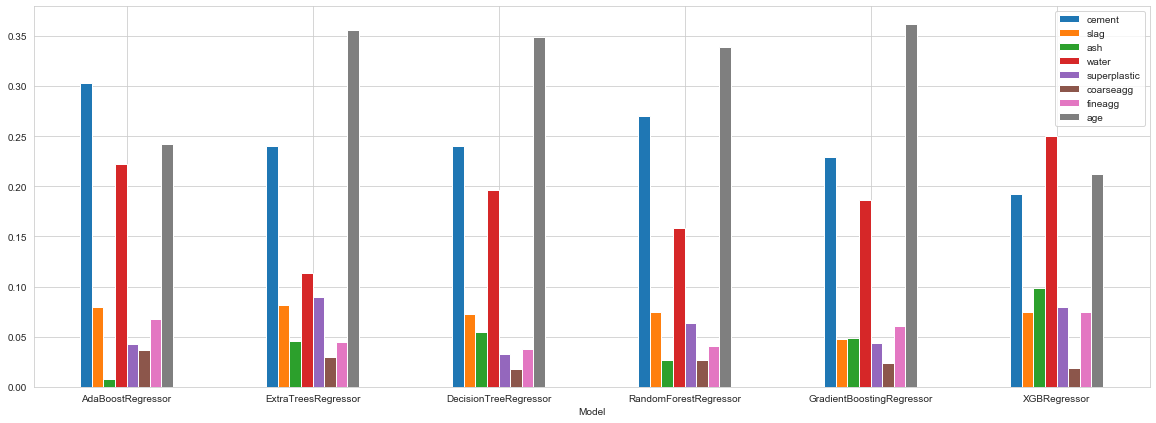

In [65]:
# Feature Importance comparison plot - by Model

df = ficompdf[ficompdf.Type=='Tuned']
df = df.drop('No.of features',axis=1)
ax = df.plot.bar(x='Model',rot=0)
plt.gcf().set_size_inches(20, 7)

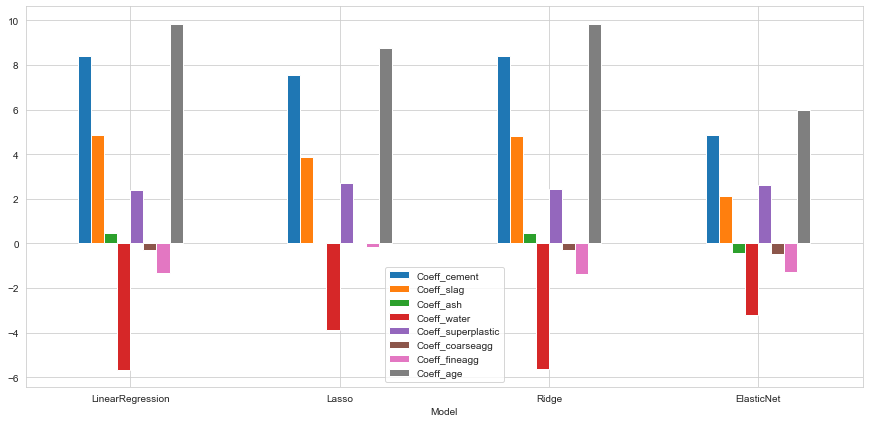

In [66]:
# Coeff comparison plot - by Model

df = paramcompdf.drop('Intercept',axis=1)
df = df[df.Type=='Base']
df = df.drop('No.of features',axis=1)
ax = df.plot.bar(x='Model',rot=0)
plt.gcf().set_size_inches(15, 7)

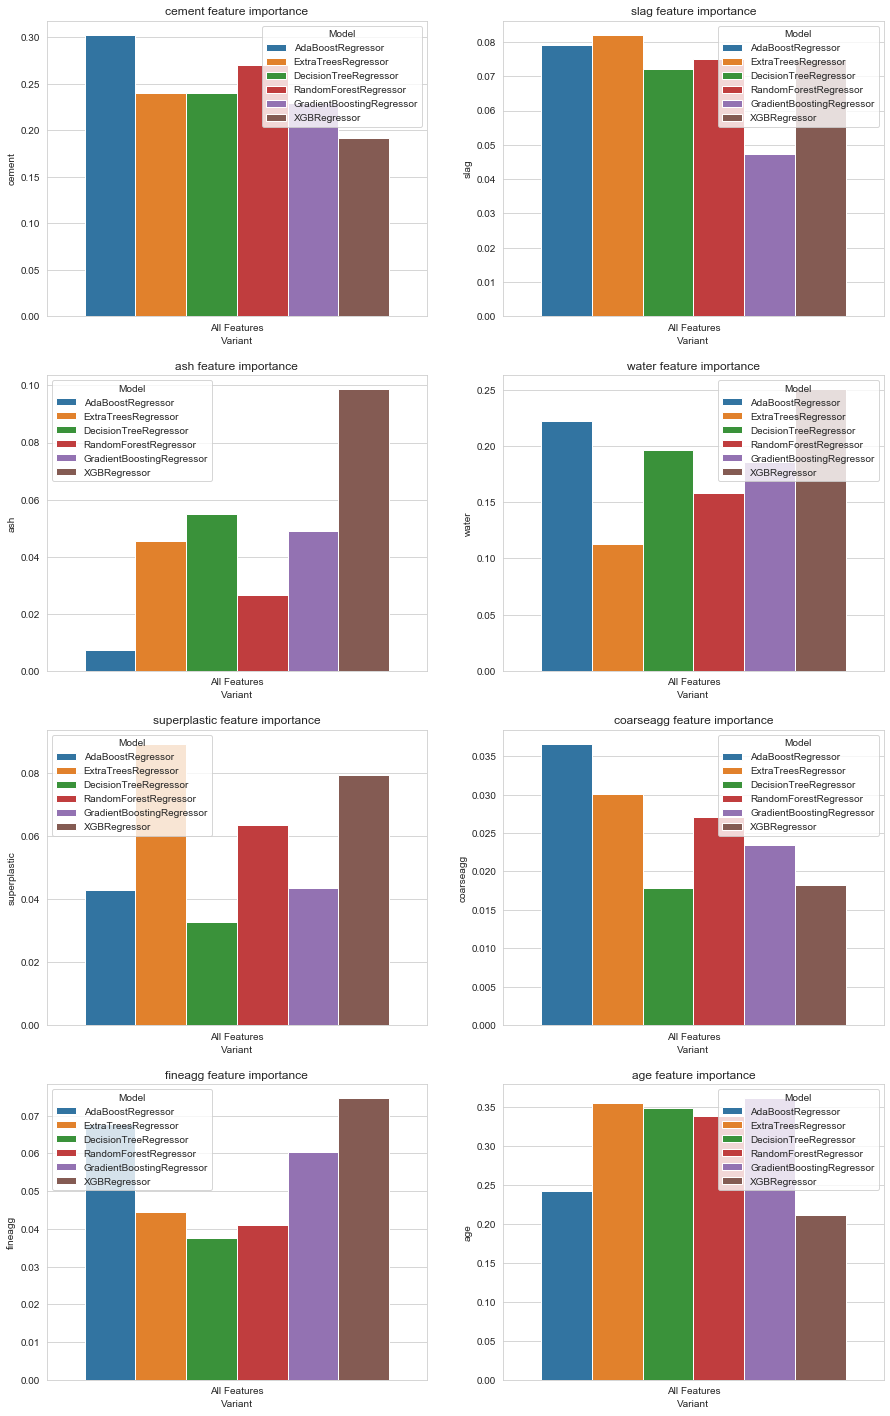

In [67]:
# Feature Importance comparison plot - by feature

attr = list(mydata.columns)
attr = attr[:-1]
plt.figure(figsize=(15,25))
counter=1
for i in attr:
    plt.subplot(4,2,counter)
    a = sns.barplot(x='Variant',y=i,hue='Model',data=ficompdf[ficompdf.Type=='Tuned']);
    rotx = a.set_xticklabels(a.get_xticklabels(), rotation=0)
    plt.title(i+" feature importance")
    counter = counter+1

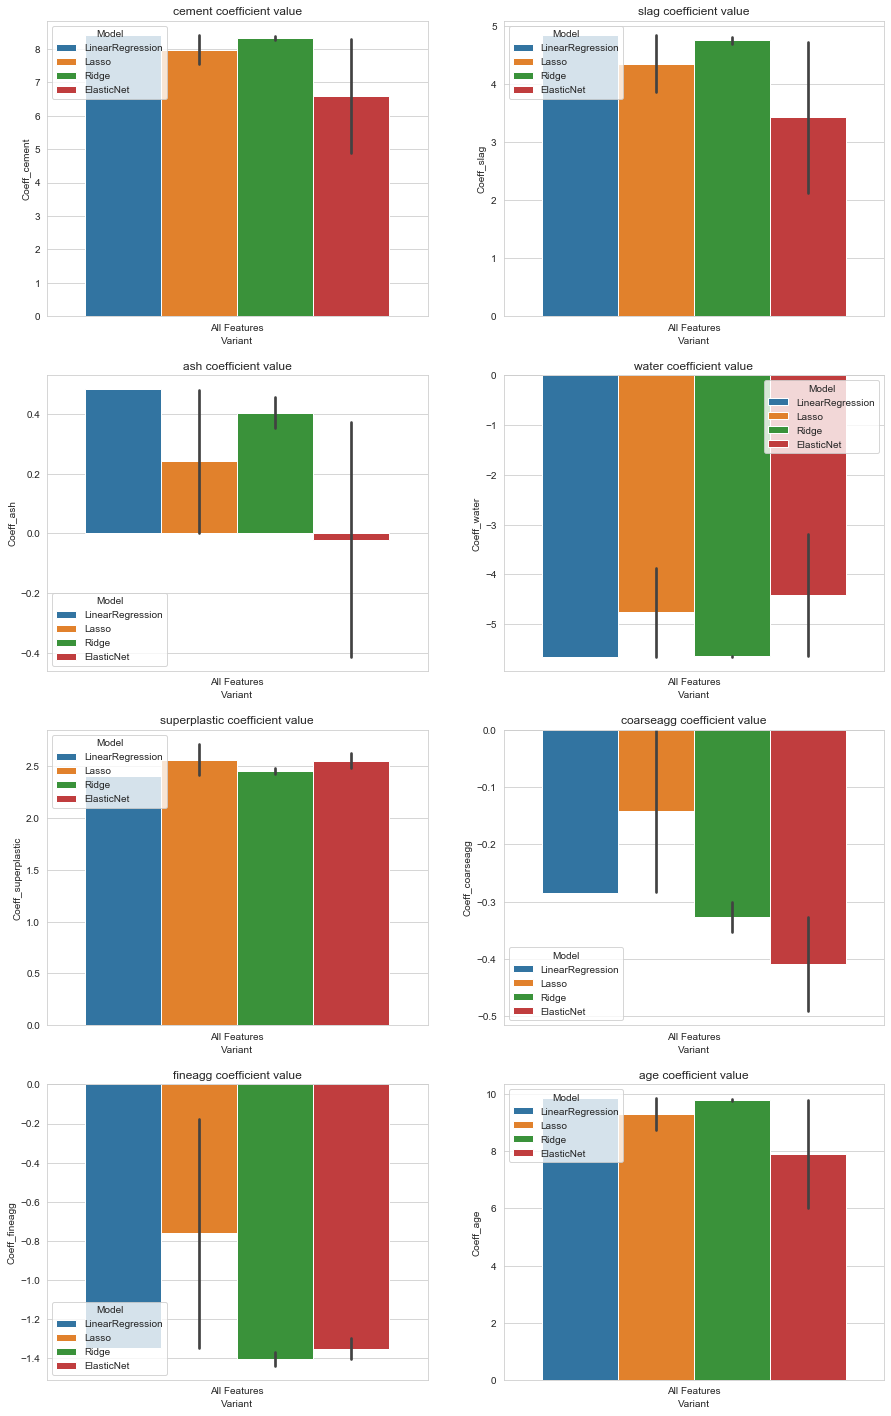

In [68]:
# Coeff comparison plot - by feature

attr = list(mydata.columns)
attr = attr[:-1]
plt.figure(figsize=(15,25))
counter=1
for i in attr:
    plt.subplot(4,2,counter)
    a = sns.barplot(x='Variant',y='Coeff_'+i,hue='Model',data=paramcompdf);
    rotx = a.set_xticklabels(a.get_xticklabels(), rotation=0)
    plt.title(i+" coefficient value")
    counter = counter+1

In [69]:
# For the XGBRegressor model ( on RFE feature data set) feature importance is computed based on SHAP approach

tind=len(mydata_rfe.columns)-1
X=mydata_rfe.iloc[:,:tind]
y=mydata_rfe.iloc[:,tind]


#creating train test split
 
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling

sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)



xgb=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=n_jobs, nthread=None, objective='reg:squarederror',
             random_state=seed, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

xgb.fit(X_train,y_train.ravel())
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
 

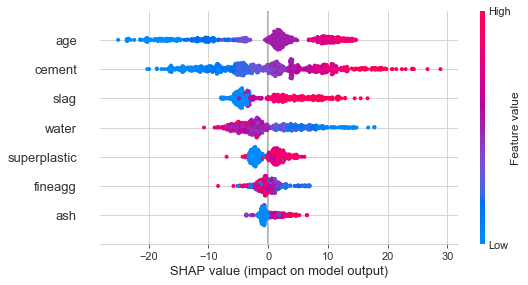

In [70]:

features_list = X.columns
shap.summary_plot(shap_values,feature_names = features_list,features= X_train)

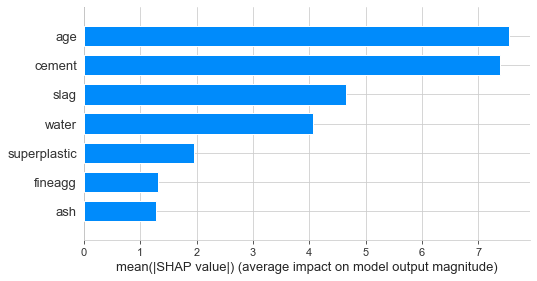

In [71]:
shap.summary_plot(shap_values,feature_names = features_list,features= X_train,plot_type='bar')

#1. Age is the feature which impacts the model the most, closely followed by cement.
#2. Ash is the feature which impacts the least.
#3. SHAP helps in explaining the model interpretability better than any other approach.